In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from itertools import combinations
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams['figure.figsize'] = [15,10]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [ ]:
df = pd.read_csv('/content/retail_store_inventory.csv')
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
df['Holiday/Promotion'] = df['Holiday/Promotion'].astype(object)
df.dtypes

,0
Date,object
Store ID,object
Product ID,object
Category,object
Region,object
Inventory Level,int64
Units Sold,int64
Units Ordered,int64
Demand Forecast,float64
Price,float64


In [ ]:
df = df.drop('Seasonality', axis = 1)

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%b')

def get_season(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Winter'
    elif month in ['Mar', 'Apr', 'May']:
        return 'Spring'
    elif month in ['Jun', 'July', 'Aug']:
        return 'Summer'
    else:
        return 'Autumn'

df['Seasonality'] = df['Month'].apply(get_season)

df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Month,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Jan,Winter
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Jan,Winter
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Jan,Winter
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Jan,Winter
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Jan,Winter


In [ ]:
low_inventory_threshold = df['Inventory Level'].quantile(0.25)

df['Stockout Risk'] = (df['Inventory Level'] < low_inventory_threshold).astype(int)

df['Stockout Risk'] = df['Stockout Risk'].map({0 : 'No', 1 : 'Yes'})

df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Month,Seasonality,Stockout Risk
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Jan,Winter,No
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Jan,Winter,No
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Jan,Winter,Yes
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Jan,Winter,No
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Jan,Winter,No


In [ ]:
df['Stockout Risk'].value_counts(normalize = True)

,proportion
Stockout Risk,
No,0.751902
Yes,0.248098


In [ ]:
df['Demand Forecast'] = df['Demand Forecast'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
#Demand-Supply Gap
df['Demand-Supply Gap'] = df['Demand Forecast'] - df['Inventory Level']

# Sales Velocity
df['Sales Velocity'] = df['Units Sold'] / (df['Inventory Level'].replace(0,1))  # avoid division by zero

df['Relative Price Difference'] = df['Price']/df['Competitor Pricing']

df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Month,Seasonality,Stockout Risk,Demand-Supply Gap,Sales Velocity,Relative Price Difference
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Jan,Winter,No,-95.53,0.549784,1.128326
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Jan,Winter,No,-59.96,0.735294,0.952388
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Jan,Winter,Yes,-27.98,0.637255,0.893678
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Jan,Winter,No,-406.82,0.130064,0.941854
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Jan,Winter,No,-156.74,0.084337,1.068020


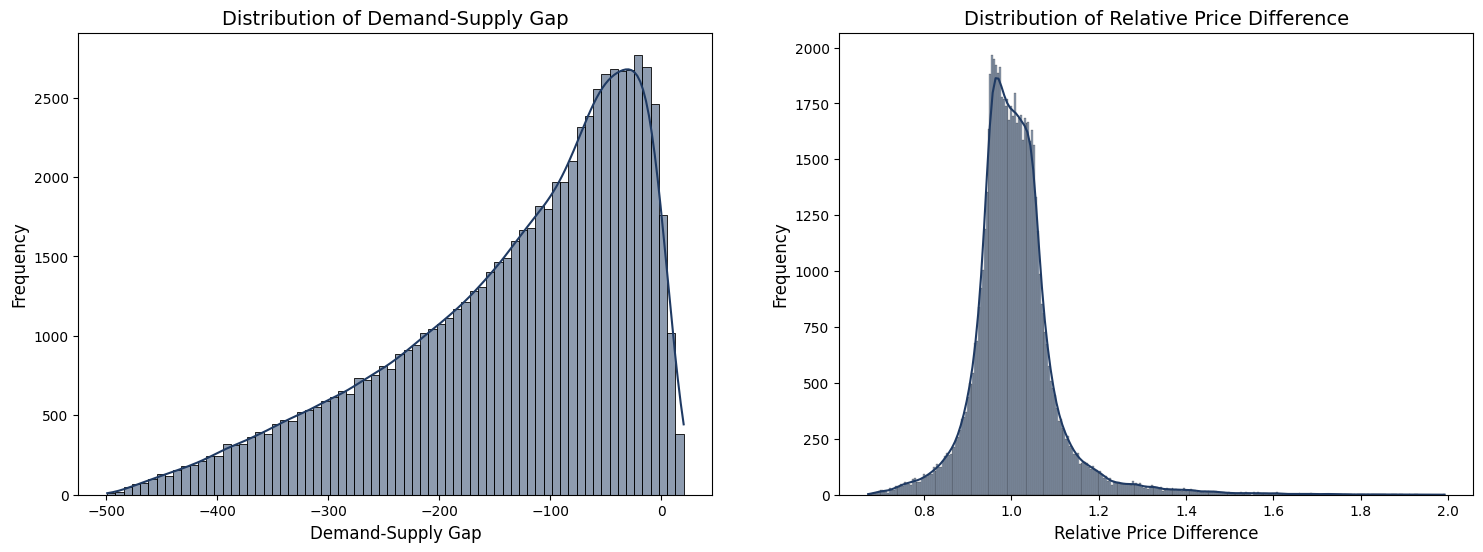

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
sns.histplot(data = df, x = 'Demand-Supply Gap', kde = True, color = '#1F3A63')
plt.title('Distribution of Demand-Supply Gap', fontsize = 14)
plt.xlabel('Demand-Supply Gap', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.subplot(1,2,2)
sns.histplot(data = df, x = 'Relative Price Difference', kde = True, color = '#1F3A63')
plt.title('Distribution of Relative Price Difference', fontsize = 14)
plt.xlabel('Relative Price Difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

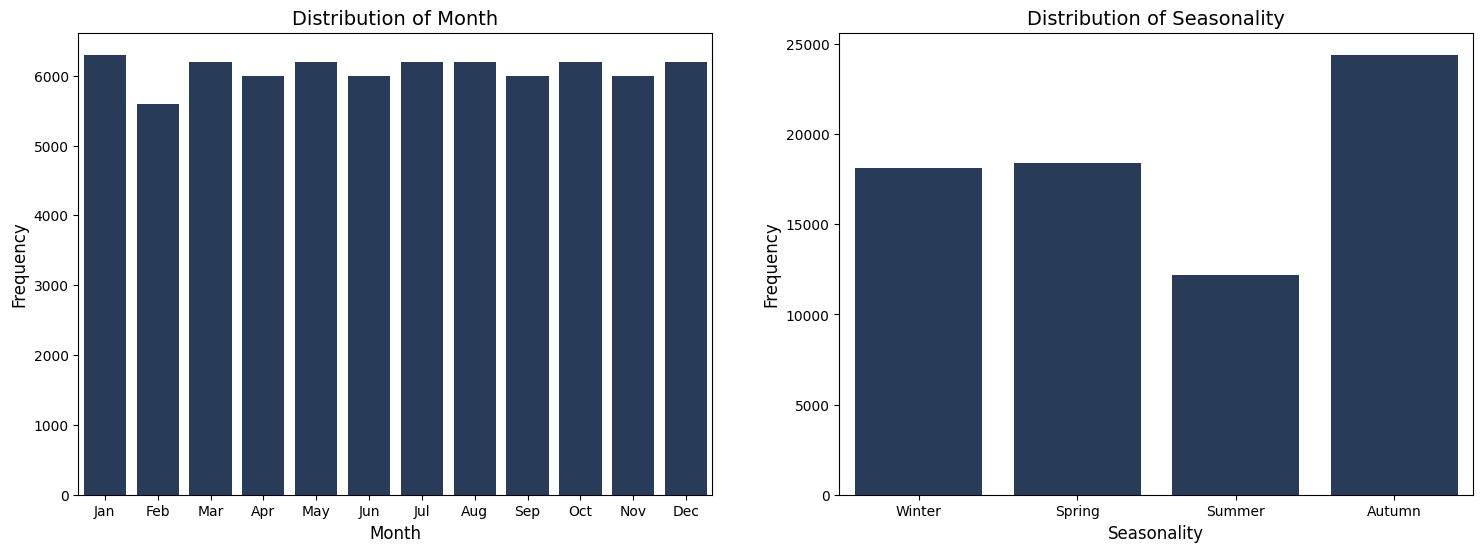

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
sns.countplot(data = df, x = 'Month', color = '#1F3A63')
plt.title('Distribution of Month', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.subplot(1,2,2)
sns.countplot(data = df, x = 'Seasonality', color = '#1F3A63')
plt.title('Distribution of Seasonality', fontsize = 14)
plt.xlabel('Seasonality', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

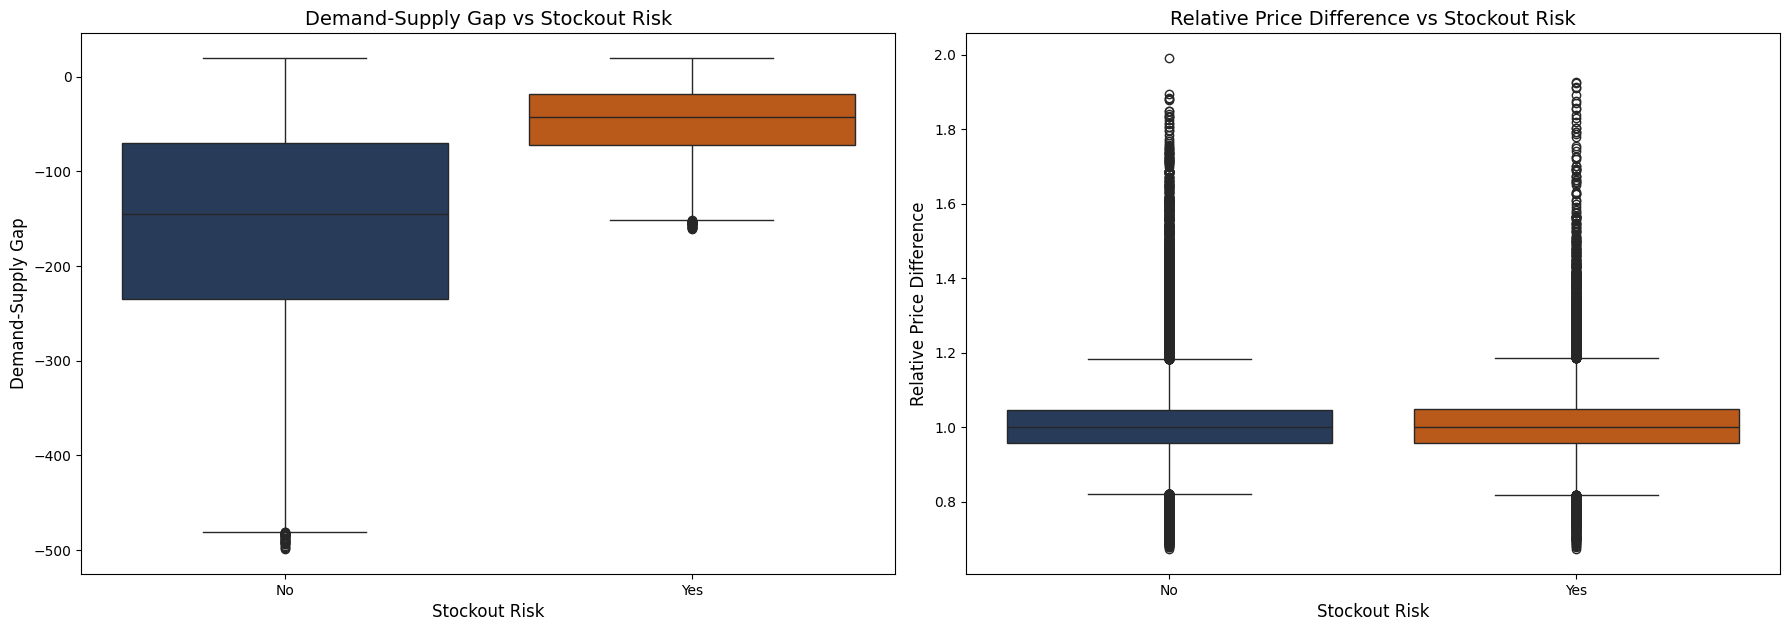

In [ ]:
cols = ['Demand-Supply Gap', 'Relative Price Difference']

stockout_palette = {'No': "#1F3A63", 'Yes': "#D35400"}

plt.figure(figsize=(18, 18))  # Adjust figure size as needed

for i, col in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data=df, x='Stockout Risk', y=col, palette=stockout_palette)
    plt.title(f'{col} vs Stockout Risk', fontsize=14)
    plt.xlabel('Stockout Risk', fontsize=12)
    plt.ylabel(col, fontsize=12)

plt.tight_layout()
plt.show()

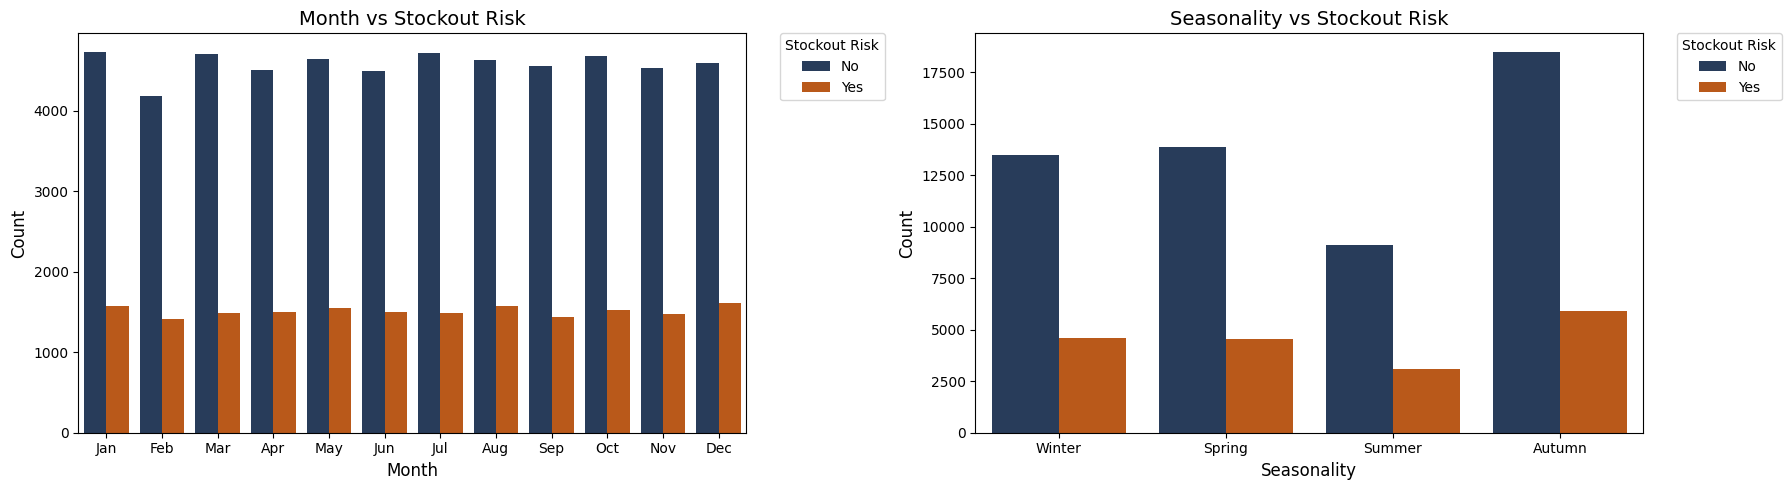

In [ ]:
cols = ['Month', 'Seasonality']
stockout_palette = {'No': "#1F3A63", 'Yes': "#D35400"}

plt.figure(figsize=(18, 5))  # Suitable for 2 plots in 1 row

for i, col in enumerate(cols):
    plt.subplot(1, 2, i + 1)
    sns.countplot(data=df, x=col, hue='Stockout Risk', palette=stockout_palette)
    plt.title(f'{col} vs Stockout Risk', fontsize=14)
    plt.legend(title='Stockout Risk', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
df.head(1)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Month,Seasonality,Stockout Risk,Demand-Supply Gap,Sales Velocity,Relative Price Difference
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.5,20,Rainy,0,29.69,Jan,Winter,No,-95.53,0.549784,1.128326


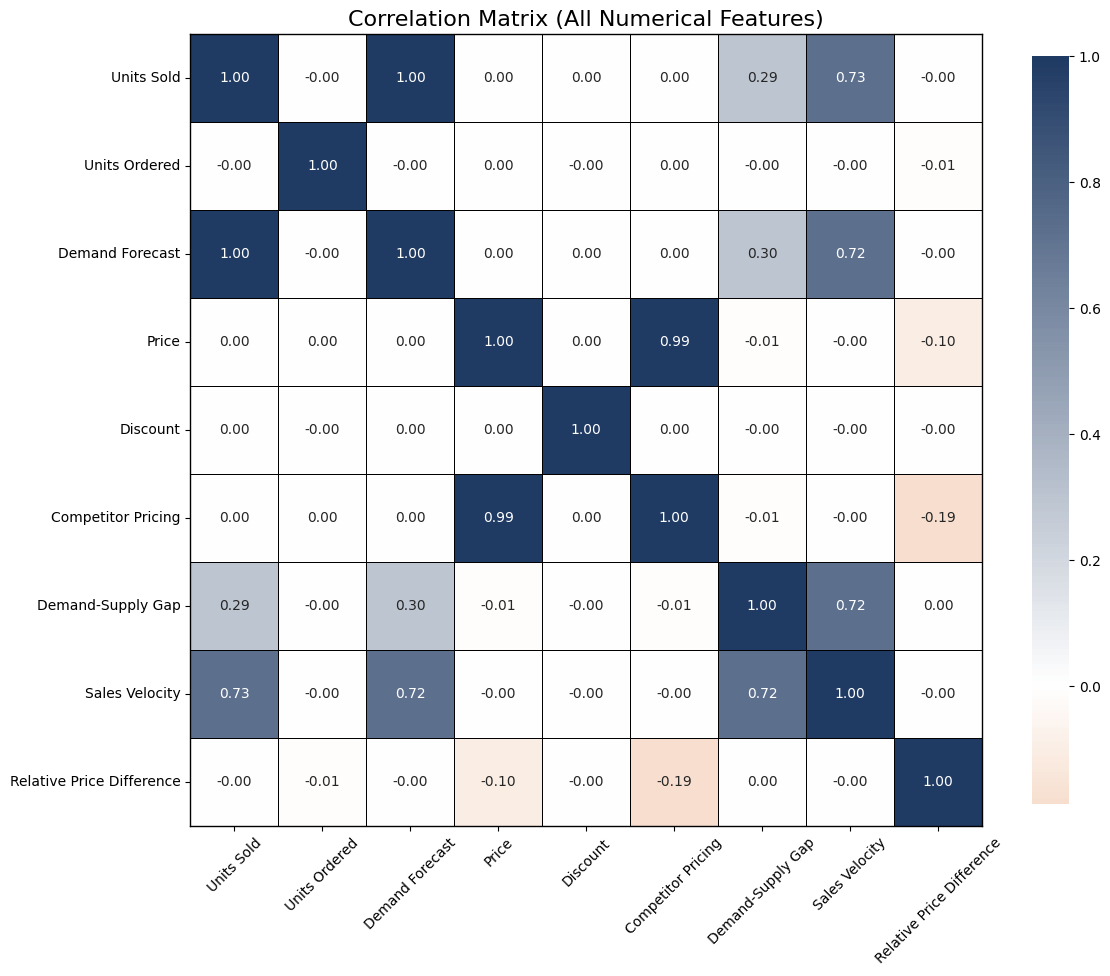

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Select only numeric columns
df_num = df.drop('Inventory Level', axis = 1).select_dtypes(include=np.number)

# Define custom diverging colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#D35400", "white", "#1F3A63"])

# Create the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    df_num.corr(),
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    linewidths=0.5,
    linecolor='black',
    square=True,
    cbar_kws={'shrink': 0.9}
)

# Force draw all spines (borders)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('black')

plt.title("Correlation Matrix (All Numerical Features)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Drop unwanted columns
df_vif = df.drop(['Date', 'Store ID', 'Product ID', 'Inventory Level'], axis=1)

df_vif = df_vif.select_dtypes(include = np.number)

# Step 4: Add constant
df_vif = add_constant(df_vif)

# Step 5: Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# Step 6: Sort and show
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data

,Feature,VIF
0,const,297.281999
6,Competitor Pricing,200.695865
4,Price,195.745081
1,Units Sold,168.093410
3,Demand Forecast,163.280129
8,Sales Velocity,5.413027
7,Demand-Supply Gap,2.819585
9,Relative Price Difference,2.467819
2,Units Ordered,1.000110
5,Discount,1.000058


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=vif_data)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
df = df.drop(['Date', 'Store ID', 'Product ID', 'Inventory Level', 'Units Sold','Demand Forecast','Price', 'Competitor Pricing'], axis = 1)

In [ ]:
df_vif = df.select_dtypes(np.number)

df_vif = add_constant(df_vif)  # Add intercept term
vif_data = pd.DataFrame()
vif_data["Feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif_data.sort_values(by = 'VIF',ascending = False)

,Feature,VIF
0,const,126.344376
3,Demand-Supply Gap,2.103521
4,Sales Velocity,2.103485
5,Relative Price Difference,1.000082
1,Units Ordered,1.000078
2,Discount,1.000024


In [ ]:
df['Month'] = df['Month'].map({'Jan' : 1,
                               'Feb' : 2,
                               'Mar' : 3,
                               'Apr' : 4,
                               'May' : 5,
                               'Jun' : 6,
                               'Jul' : 7,
                               'Aug' : 8,
                               'Sep' : 9,
                               'Oct' : 10,
                               'Nov' : 11,
                               'Dec' : 12})

In [ ]:
categorical_cols = ['Category', 'Region', 'Weather Condition',
                    'Seasonality']

encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_array = encoder.fit_transform(df[categorical_cols])

encoded_col_names = encoder.get_feature_names_out(categorical_cols)

df_encoded = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df.index)

df = pd.concat([df.drop(columns=categorical_cols), df_encoded], axis=1)

df.head()

,Units Ordered,Discount,Holiday/Promotion,Month,Stockout Risk,Demand-Supply Gap,Sales Velocity,Relative Price Difference,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys,Region_North,Region_South,Region_West,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,55,20,0,1,No,-95.53,0.549784,1.128326,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,66,20,0,1,No,-59.96,0.735294,0.952388,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,51,10,1,1,Yes,-27.98,0.637255,0.893678,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,164,10,1,1,No,-406.82,0.130064,0.941854,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,135,0,0,1,No,-156.74,0.084337,1.068020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
X=df.drop('Stockout Risk',axis=1)
y=df['Stockout Risk']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(51170, 20)
(21930, 20)
(51170,)
(21930,)


In [ ]:
pt = PowerTransformer(method='yeo-johnson')  # Works with negative & zero values
X_train[['Relative Price Difference']] = pt.fit_transform(X_train[['Relative Price Difference']])
X_test[['Relative Price Difference']] = pt.transform(X_test[['Relative Price Difference']])

train_skewness = X_train['Relative Price Difference'].skew()
test_skewness = X_test['Relative Price Difference'].skew()

print(f'Skewness of Relative Price Diff in training set : {train_skewness:.2f}')
print(f'Skewness of Relative Price Diff in test set : {test_skewness:.2f}')

Skewness of Relative Price Diff in training set : -0.18
Skewness of Relative Price Diff in test set : -0.18


In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')  # Works with negative & zero values
X_train[['Demand-Supply Gap']] = pt.fit_transform(X_train[['Demand-Supply Gap']])
X_test[['Demand-Supply Gap']] = pt.transform(X_test[['Demand-Supply Gap']])

train_skewness = X_train['Demand-Supply Gap'].skew()
test_skewness = X_test['Demand-Supply Gap'].skew()

print(f'Skewness of Demand-Supply Gap in training set : {train_skewness:.2f}')
print(f'Skewness of Demand-Supply Gap in test set : {test_skewness:.2f}')

Skewness of Demand-Supply Gap in training set : -0.07
Skewness of Demand-Supply Gap in test set : -0.07


In [ ]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['Units Ordered', 'Discount', 'Month', 'Relative Price Difference', 'Demand-Supply Gap', 'Sales Velocity']

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Transform test data
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

X_train.head()

,Units Ordered,Discount,Holiday/Promotion,Month,Demand-Supply Gap,Sales Velocity,Relative Price Difference,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys,Region_North,Region_South,Region_West,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
61925,-1.623187,0.705227,0,0.722620,-0.918131,-1.050346,-0.545726,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36316,1.628472,-1.407564,1,1.593569,1.080966,0.753788,0.150564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29247,1.456325,-1.407564,0,1.012936,-0.576784,-0.275812,0.619556,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40876,-1.336276,0.705227,0,-1.309596,-0.309160,-1.469904,-0.988406,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36711,-0.877218,-1.407564,1,-1.599912,-0.135710,0.225276,0.370856,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Label encoder for XGBoost, if needed
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Custom color map for confusion matrix
labels = ['No', 'Yes']
custom_blues = LinearSegmentedColormap.from_list("custom_blues", ['white', '#1F3A63'])

# Confusion matrix plot function
def plot_conf_matrix(y_true, y_pred, title):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=labels,
        cmap=custom_blues,
        colorbar=False
    )
    disp.ax_.set_title(title, fontsize=13, weight='bold')
    disp.ax_.tick_params(labelsize=11)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Preprocessor for pipelines (used by tree-based models needing encoding)
categorical_features = ['Holiday/Promotion']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Model definitions
model = LogisticRegression(random_state=42)
gnb_model = GaussianNB()
linear_svc_model = LinearSVC(random_state=42, max_iter=10000)
rf_model = RandomForestClassifier(random_state=42)
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])
# LightGBM skipped due to unavailable package in this runtime (add if available)
pipeline_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())  # Placeholder for LightGBM if not available
])
mlp_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])
dt_model = DecisionTreeClassifier(random_state=42)
ab_model = AdaBoostClassifier(random_state=42)
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])
et_model = ExtraTreesClassifier(random_state=42)

# Evaluate models
model_blocks = [
    ("Logistic Regression", model, y_train, y_test, "predict_proba"),
    ("GaussianNB", gnb_model, y_train, y_test, "predict_proba"),
    ("LinearSVC", linear_svc_model, y_train, y_test, "decision_function"),
    ("Random Forest", rf_model, y_train, y_test, "predict_proba"),
    ("XGBoost", pipeline_xgb, y_train_enc, y_test_enc, "predict_proba"),
    ("LightGBM", pipeline_lgb, y_train_enc, y_test_enc, "predict_proba"),
    ("MLP", mlp_model, y_train, y_test, "predict_proba"),
    ("Decision Tree", dt_model, y_train, y_test, "predict_proba"),
    ("AdaBoost", ab_model, y_train, y_test, "predict_proba"),
    ("KNN", knn_model, y_train, y_test, "predict_proba"),
    ("Extra Trees", et_model, y_train, y_test, "predict_proba")
]

# Evaluate models
for name, model, y_train_true, y_test_true, method in model_blocks:
    print(f"🔍 {name}")
    print("-" * len(f"🔍 {name}"))

    # ✅ Fit the model
    model.fit(X_train, y_train_true)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Confusion Matrices
    #plot_conf_matrix(y_train_true, y_train_pred, f"{name} - Train Confusion Matrix")
    #plot_conf_matrix(y_test_true, y_test_pred, f"{name} - Test Confusion Matrix")

    # Classification Reports
    print("Train Report Before SMOTE:\n", classification_report(y_train_true, y_train_pred))
    print("Test Report Before SMOTE:\n", classification_report(y_test_true, y_test_pred))

    # ROC AUC Scores
    if method == "predict_proba":
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:  # decision_function
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)

    print("ROC AUC Score (Train):", roc_auc_score(y_train_true, y_train_proba))
    print("ROC AUC Score (Test):", roc_auc_score(y_test_true, y_test_proba))
    print("-" * 60)


🔍 Logistic Regression
---------------------
Train Report Before SMOTE:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     38485
           1       0.86      0.77      0.81     12685

    accuracy                           0.91     51170
   macro avg       0.89      0.86      0.88     51170
weighted avg       0.91      0.91      0.91     51170

Test Report Before SMOTE:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     16479
           1       0.86      0.77      0.82      5451

    accuracy                           0.91     21930
   macro avg       0.90      0.87      0.88     21930
weighted avg       0.91      0.91      0.91     21930

ROC AUC Score (Train): 0.9662769737263579
ROC AUC Score (Test): 0.9682274919723771
------------------------------------------------------------
🔍 GaussianNB
------------
Train Report Before SMOTE:
               precision    recall  f1-score   sup

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier


# Resample training data with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Identify categorical columns
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical columns as they are
)

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit on the training target labels
y_train_encoded = le.fit_transform(y_train_smote)
y_test_encoded = le.transform(y_test)


# Models trained on SMOTE-resampled data
model_blocks_smote = [
    ("Logistic Regression (SMOTE)", LogisticRegression(random_state=42), y_train_smote, y_test, "predict_proba"),
    ("GaussianNB (SMOTE)", GaussianNB(), y_train_smote, y_test, "predict_proba"),
    ("LinearSVC (SMOTE)", LinearSVC(random_state=42, max_iter=10000), y_train_smote, y_test, "decision_function"),
    ("Random Forest (SMOTE)", RandomForestClassifier(random_state=42), y_train_smote, y_test, "predict_proba"),
    ("XGBoost (SMOTE)", make_pipeline(preprocessor, XGBClassifier(eval_metric='logloss', random_state=42)),
     le.fit_transform(y_train_smote), le.transform(y_test), "predict_proba"),
    ("LightGBM (SMOTE)", make_pipeline(preprocessor, LGBMClassifier(verbose=-1, random_state=42)),
     le.fit_transform(y_train_smote), le.transform(y_test), "predict_proba"),
    ("MLP (SMOTE)", make_pipeline(StandardScaler(), MLPClassifier(random_state=42)), y_train_smote, y_test, "predict_proba"),
    ("Decision Tree (SMOTE)", DecisionTreeClassifier(random_state=42), y_train_smote, y_test, "predict_proba"),
    ("AdaBoost (SMOTE)", AdaBoostClassifier(random_state=42), y_train_smote, y_test, "predict_proba"),
    ("KNN (SMOTE)", KNeighborsClassifier(), y_train_smote, y_test, "predict_proba"),
    ("Extra Trees (SMOTE)", ExtraTreesClassifier(random_state=42), y_train_smote, y_test, "predict_proba")
]

# Train and evaluate SMOTE models
for name, model, y_train_true, y_test_true, method in model_blocks_smote:
    print(f"🔍 {name}")
    print("-" * len(f"🔍 {name}"))

    # Fit the model
    model.fit(X_train_smote, y_train_true)

    # Predictions
    y_train_pred = model.predict(X_train_smote)
    y_test_pred = model.predict(X_test)

    # Confusion Matrices
    #plot_conf_matrix(y_train_true, y_train_pred, f"{name} - Train Confusion Matrix")
    #plot_conf_matrix(y_test_true, y_test_pred, f"{name} - Test Confusion Matrix")

    # Classification Reports
    print("Train Report After SMOTE:\n", classification_report(y_train_true, y_train_pred))
    print("Test Report After SMOTE:\n", classification_report(y_test_true, y_test_pred))

    # ROC AUC
    if method == "predict_proba":
        y_train_proba = model.predict_proba(X_train_smote)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train_smote)
        y_test_proba = model.decision_function(X_test)

    print("ROC AUC Score (Train):", roc_auc_score(y_train_true, y_train_proba))
    print("ROC AUC Score (Test):", roc_auc_score(y_test_true, y_test_proba))
    print("-" * 60)


🔍 Logistic Regression (SMOTE)
-----------------------------
Train Report After SMOTE:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     38485
           1       0.91      0.95      0.93     38485

    accuracy                           0.93     76970
   macro avg       0.93      0.93      0.93     76970
weighted avg       0.93      0.93      0.93     76970

Test Report After SMOTE:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     16479
           1       0.77      0.93      0.84      5451

    accuracy                           0.91     21930
   macro avg       0.87      0.92      0.89     21930
weighted avg       0.92      0.91      0.92     21930

ROC AUC Score (Train): 0.9703546198388427
ROC AUC Score (Test): 0.9691380530909022
------------------------------------------------------------
🔍 GaussianNB (SMOTE)
--------------------
Train Report After SMOTE:
               precis

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Report After SMOTE:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     38485
           1       0.95      0.97      0.96     38485

    accuracy                           0.96     76970
   macro avg       0.96      0.96      0.96     76970
weighted avg       0.96      0.96      0.96     76970

Test Report After SMOTE:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     16479
           1       0.83      0.89      0.86      5451

    accuracy                           0.93     21930
   macro avg       0.90      0.91      0.90     21930
weighted avg       0.93      0.93      0.93     21930

ROC AUC Score (Train): 0.994989814378748
ROC AUC Score (Test): 0.9823134415366227
------------------------------------------------------------
🔍 Decision Tree (SMOTE)
-----------------------
Train Report After SMOTE:
               precision    recall  f1-score   support

           0       1

In [ ]:

# ------------------------
# 1. Logistic Regression
# ------------------------

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import StratifiedKFold

param_grid = [
    {
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
    },
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga', 'lbfgs'],
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1],
        'solver': ['saga'],
        'l1_ratio': [0.3, 0.5, 0.7]  # Required for elasticnet
    },
    {
        'penalty': [None],
        'solver': ['lbfgs', 'newton-cg'],
        'C': [1]  # C is ignored when no penalty, but required by API
    }
]



# Define a custom scorer
recall_scorer = make_scorer(recall_score, pos_label='Yes')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_log = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                    param_grid,
                    scoring=recall_scorer,
                    cv=cv,
                    n_jobs=-1,
                    error_score='raise')

grid_log.fit(X_train, y_train)
best_log = grid_log.best_estimator_
print(f"Best Params of Logistic Regression: {grid_log.best_params_}")
print()


# ------------------------
# 2. GaussianNB
# ------------------------

print("Naive Bayes is fast and has no tunable hyperparameters in sklearn")
print()


# ------------------------
# 3. Random Forest
# ------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Define a custom scorer
recall_scorer = make_scorer(recall_score, pos_label='Yes')


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}


from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=8,
    scoring=recall_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
print(f"Best Params of Random Forest: {random_search.best_params_}")
print()


# ------------------------
# 4. XGBoost
# ------------------------

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold


# Separate categorical and numeric columns
categorical_features = ['Holiday/Promotion']  # Add more if needed
numeric_features = [col for col in X_train.columns if col not in categorical_features]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
], remainder='passthrough')  # Keep numeric columns as-is

# Label encode target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state = 42))
])

# Grid search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(pipeline, param_grid, scoring='recall', cv=cv)
grid_xgb.fit(X_train, y_train_encoded)

best_xgb = grid_xgb.best_estimator_
print(f"Best Params OF XGBoost: {grid_xgb.best_params_}")
print()

# ------------------------
# 5. Linear SVC SVM
# ------------------------

from sklearn.svm import LinearSVC

param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    LinearSVC(max_iter=5000, random_state=42),
    param_distributions=param_grid,
    n_iter=3,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_linear_svc = random_search.best_estimator_
print(f"Best Params of SVM: {random_search.best_params_}")
print()

# ------------------------
# 6. LightGBM
# ------------------------

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LGBMClassifier(verbosity = -1, random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [5, 10]
}

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_lgb = GridSearchCV(pipeline, param_grid, scoring='recall', cv=cv, n_jobs=-1)
grid_lgb.fit(X_train, y_train_encoded)

best_lgb = grid_lgb.best_estimator_
print(f"Best Params of LightGBM: {grid_lgb.best_params_}")
print()

# ------------------------
# 7. MLPClassifier
# ------------------------

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# MLP benefits from scaling
pipeline = Pipeline([
    ('preprocessing', StandardScaler()),  # apply scaling
    ('classifier', MLPClassifier(max_iter=300, random_state=42))
])

param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__alpha': [0.0001, 0.001],
    'classifier__learning_rate_init': [0.001, 0.01]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_mlp = GridSearchCV(pipeline, param_grid, scoring='recall', cv=cv, n_jobs=-1)
grid_mlp.fit(X_train, y_train)

best_mlp = grid_mlp.best_estimator_
print(f"Best Params of MLPClassifier: {grid_mlp.best_params_}")
print()


# ------------------------
# 8. Decision Tree
# ------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring=recall_scorer,
    cv=cv,
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print(f"Best Params of Decision Tree: {grid_dt.best_params_}")
print()

# ------------------------
# 9. AdaBoost
# ------------------------
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 1.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_ab = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid,
    scoring=recall_scorer,
    cv=cv,
    n_jobs=-1
)
grid_ab.fit(X_train, y_train)
best_ab = grid_ab.best_estimator_
print(f"Best Params of AdaBoost: {grid_ab.best_params_}")
print()

# ------------------------
# 10. K-Nearest Neighbors (KNN)
# ------------------------
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  # Manhattan or Euclidean
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_knn = GridSearchCV(
    pipeline_knn,
    param_grid,
    scoring=recall_scorer,
    cv=cv,
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print(f"Best Params of KNN: {grid_knn.best_params_}")
print()

# ------------------------
# 11. Extra Trees
# ------------------------
from sklearn.ensemble import ExtraTreesClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

grid_et = GridSearchCV(
    ExtraTreesClassifier(random_state=42),
    param_grid,
    scoring=recall_scorer,
    cv=5,
    n_jobs=-1
)
grid_et.fit(X_train, y_train)
best_et = grid_et.best_estimator_
print(f"Best Params of Extra Trees: {grid_et.best_params_}")
print()


Best Params of Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Naive Bayes is fast and has no tunable hyperparameters in sklearn

Best Params of Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10, 'class_weight': 'balanced'}

Best Params OF XGBoost: {'classifier__max_depth': 3, 'classifier__n_estimators': 100}



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Best Params of SVM: {'class_weight': 'balanced', 'C': 0.1}

Best Params of LightGBM: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params of MLPClassifier: {'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate_init': 0.001}

Best Params of Decision Tree: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}

Best Params of AdaBoost: {'learning_rate': 1.5, 'n_estimators': 200}

Best Params of KNN: {'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}



/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params of Extra Trees: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Label encode where needed
le = LabelEncoder()
y_train_res_enc = le.fit_transform(y_train_resampled)
y_test_enc = le.transform(y_test)

# Categorical preprocessing
categorical_features = ['Holiday/Promotion']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

recall_scorer = make_scorer(recall_score, pos_label='Yes')

# 1. Logistic Regression
param_grid_log = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga', 'lbfgs']},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1], 'solver': ['saga'], 'l1_ratio': [0.3, 0.5, 0.7]},
    {'penalty': [None], 'solver': ['lbfgs', 'newton-cg'], 'C': [1]}
]
grid_log = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_log, scoring=recall_scorer, cv=5, n_jobs=-1)
grid_log.fit(X_train_resampled, y_train_resampled)
best_log = grid_log.best_estimator_
print("Best Params of Logistic Regression:", grid_log.best_params_)

# 2. GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_train_resampled, y_train_resampled)
print("Naive Bayes has no hyperparameters to tune.")

# 3. Random Forest
param_grid_rf = {
    'n_estimators': [100, 200], 'max_depth': [None, 10],
    'min_samples_split': [2, 5], 'class_weight': ['balanced']
}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_grid_rf, n_iter=8, scoring=recall_scorer, cv=5, n_jobs=-1)
random_search_rf.fit(X_train_resampled, y_train_resampled)
best_rf = random_search_rf.best_estimator_
print("Best Params of Random Forest:", random_search_rf.best_params_)

# 4. XGBoost
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])
param_grid_xgb = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 5]}
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, scoring='recall', cv=5)
grid_xgb.fit(X_train_resampled, y_train_res_enc)
best_xgb = grid_xgb.best_estimator_
print("Best Params of XGBoost:", grid_xgb.best_params_)

# 5. Linear SVC
param_grid_svc = {'C': [0.1, 1, 10], 'class_weight': ['balanced']}
random_search_svc = RandomizedSearchCV(LinearSVC(max_iter=5000, random_state=42), param_distributions=param_grid_svc, n_iter=3, scoring='recall', cv=3, n_jobs=-1)
random_search_svc.fit(X_train_resampled, y_train_resampled)
best_linear_svc = random_search_svc.best_estimator_
print("Best Params of Linear SVC:", random_search_svc.best_params_)

# 6. LightGBM
pipeline_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(verbosity=-1, random_state=42))
])
param_grid_lgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [5, 10]
}
grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, scoring='recall', cv=5, n_jobs=-1)
grid_lgb.fit(X_train_resampled, y_train_res_enc)
best_lgb = grid_lgb.best_estimator_
print("Best Params of LightGBM:", grid_lgb.best_params_)

# 7. MLP
pipeline_mlp = Pipeline([
    ('preprocessing', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=300, random_state=42))
])
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__alpha': [0.0001, 0.001],
    'classifier__learning_rate_init': [0.001, 0.01]
}
grid_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, scoring='recall', cv=3, n_jobs=-1)
grid_mlp.fit(X_train_resampled, y_train_resampled)
best_mlp = grid_mlp.best_estimator_
print("Best Params of MLPClassifier:", grid_mlp.best_params_)

# 8. Decision Tree
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, scoring=recall_scorer, cv=5, n_jobs=-1)
grid_dt.fit(X_train_resampled, y_train_resampled)
best_dt = grid_dt.best_estimator_
print("Best Params of Decision Tree:", grid_dt.best_params_)

# 9. AdaBoost
param_grid_ab = {'n_estimators': [50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]}
grid_ab = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ab, scoring=recall_scorer, cv=5, n_jobs=-1)
grid_ab.fit(X_train_resampled, y_train_resampled)
best_ab = grid_ab.best_estimator_
print("Best Params of AdaBoost:", grid_ab.best_params_)

# 10. KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, scoring=recall_scorer, cv=5, n_jobs=-1)
grid_knn.fit(X_train_resampled, y_train_resampled)
best_knn = grid_knn.best_estimator_
print("Best Params of KNN:", grid_knn.best_params_)

# 11. Extra Trees
param_grid_et = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}
grid_et = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid_et, scoring=recall_scorer, cv=5, n_jobs=-1)
grid_et.fit(X_train_resampled, y_train_resampled)
best_et = grid_et.best_estimator_
print("Best Params of Extra Trees:", grid_et.best_params_)


Best Params of Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Naive Bayes has no hyperparameters to tune.
Best Params of Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10, 'class_weight': 'balanced'}
Best Params of XGBoost: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Best Params of Linear SVC: {'class_weight': 'balanced', 'C': 0.1}
Best Params of LightGBM: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params of MLPClassifier: {'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate_init': 0.001}
Best Params of Decision Tree: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best Params of AdaBoost: {'learning_rate': 0.5, 'n_estimators': 100}
Best Params of KNN: {'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params of Extra Trees: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE

# Step 1: Encode 'Yes'/'No' labels to 1/0
y_train = y_train.replace({'No': 0, 'Yes': 1})
y_test = y_test.replace({'No': 0, 'Yes': 1})

# Step 2: Encode categorical features
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Step 3: Align columns (handle mismatch in one-hot columns)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Step 5: Define tuned models
models = {
    "Logistic Regression": LogisticRegression(C=0.01, penalty='l2', solver='liblinear'),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVC": LinearSVC(class_weight='balanced', C=0.1, max_iter=10000),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=5, use_label_encoder=False, eval_metric='logloss'),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), alpha=0.0001, learning_rate_init=0.001, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=2, criterion='entropy', class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.5),
    "KNN": KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, max_depth=10, min_samples_split=2, class_weight='balanced')
}

# Step 6: Initialize results dictionary
results = {
    "Model": [],
    "Train Recall (Yes)": [],
    "Test Recall (Yes)": [],
    "Train F1 (Yes)": [],
    "Test F1 (Yes)": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
    "Train ROC AUC": [],
    "Test ROC AUC": []
}

# Step 7: Evaluate models
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test_encoded)

    # Use probabilities or decision function for ROC AUC
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train_resampled)[:, 1]
        y_test_proba = model.predict_proba(X_test_encoded)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train_resampled)
        y_test_proba = model.decision_function(X_test_encoded)

    # Store results
    results["Model"].append(name)
    results["Train Recall (Yes)"].append(round(recall_score(y_train_resampled, y_train_pred, pos_label=1), 2))
    results["Test Recall (Yes)"].append(round(recall_score(y_test, y_test_pred, pos_label=1), 2))
    results["Train F1 (Yes)"].append(round(f1_score(y_train_resampled, y_train_pred, pos_label=1), 2))
    results["Test F1 (Yes)"].append(round(f1_score(y_test, y_test_pred, pos_label=1), 2))
    results["Train Accuracy"].append(round(accuracy_score(y_train_resampled, y_train_pred), 2))
    results["Test Accuracy"].append(round(accuracy_score(y_test, y_test_pred), 2))
    results["Train ROC AUC"].append(round(roc_auc_score(y_train_resampled, y_train_proba), 2))
    results["Test ROC AUC"].append(round(roc_auc_score(y_test, y_test_proba), 2))

# Step 8: Create and display DataFrame
df_final_results = pd.DataFrame(results)
df_final_results

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:09:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Train Recall (Yes),Test Recall (Yes),Train F1 (Yes),Test F1 (Yes),Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC
0,Logistic Regression,0.96,0.94,0.93,0.84,0.93,0.91,0.97,0.97
1,Gaussian Naive Bayes,0.88,0.85,0.79,0.59,0.77,0.71,0.83,0.82
2,Linear SVC,0.95,0.93,0.93,0.84,0.92,0.91,0.97,0.97
3,Random Forest,0.99,0.96,0.92,0.77,0.92,0.86,0.99,0.97
4,XGBoost,0.97,0.87,0.97,0.87,0.97,0.94,1.00,0.99
5,MLP,0.96,0.91,0.95,0.86,0.95,0.93,0.99,0.98
6,Decision Tree,0.99,0.98,0.91,0.77,0.90,0.86,0.96,0.96
7,AdaBoost,0.99,0.98,0.91,0.78,0.91,0.86,0.98,0.98
8,KNN,1.00,0.65,1.00,0.60,1.00,0.79,1.00,0.81
9,Extra Trees,0.98,0.93,0.89,0.71,0.88,0.81,0.97,0.93


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_auc_score

# LightGBM with tuned hyperparameters
lgbm_model = LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=100)

# Fit on SMOTE-resampled training data
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_train_pred = lgbm_model.predict(X_train_resampled)
y_test_pred = lgbm_model.predict(X_test_encoded)

# Probabilities for ROC AUC
y_train_proba = lgbm_model.predict_proba(X_train_resampled)[:, 1]
y_test_proba = lgbm_model.predict_proba(X_test_encoded)[:, 1]

# Metrics
print("🔹 LightGBM Classifier Evaluation 🔹")
print("Train Recall (Yes):", round(recall_score(y_train_resampled, y_train_pred, pos_label=1), 2))
print("Test Recall (Yes):", round(recall_score(y_test, y_test_pred, pos_label=1), 2))
print("Train F1 (Yes):", round(f1_score(y_train_resampled, y_train_pred, pos_label=1), 2))
print("Test F1 (Yes):", round(f1_score(y_test, y_test_pred, pos_label=1), 2))
print("Train Accuracy:", round(accuracy_score(y_train_resampled, y_train_pred), 2))
print("Test Accuracy:", round(accuracy_score(y_test, y_test_pred), 2))
print("Train ROC AUC:", round(roc_auc_score(y_train_resampled, y_train_proba), 2))
print("Test ROC AUC:", round(roc_auc_score(y_test, y_test_proba), 2))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 38485, number of negative: 38485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4838
[LightGBM] [Info] Number of data points in the train set: 76970, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [ ]:
# Extended best parameters table including Decision Tree, AdaBoost, KNN, Extra Trees
best_params_table = {
    "Model": [
        "Logistic Regression",
        "GaussianNB",
        "LinearSVC",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "MLPClassifier",
        "Decision Tree",
        "AdaBoost",
        "KNN",
        "Extra Trees"
    ],
    "Best Params": [
        str(grid_log.best_params_),
        "No hyperparameters to tune",
        str(best_linear_svc.get_params()),
        str(best_rf.get_params()),
        str(grid_xgb.best_params_),
        str(grid_lgb.best_params_),
        str(grid_mlp.best_params_),
        str(grid_dt.best_params_),
        str(grid_ab.best_params_),
        str(grid_knn.best_params_),
        str(grid_et.best_params_)
    ]
}

df_best_params_all = pd.DataFrame(best_params_table)
df_best_params_all


,Model,Best Params
0,Logistic Regression,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}"
1,GaussianNB,No hyperparameters to tune
2,LinearSVC,"{'C': 0.1, 'class_weight': 'balanced', 'dual': 'auto', 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 5000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}"
3,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"
4,XGBoost,"{'classifier__max_depth': 3, 'classifier__n_estimators': 100}"
5,LightGBM,"{'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}"
6,MLPClassifier,"{'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate_init': 0.001}"
7,Decision Tree,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}"
8,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 200}"
9,KNN,"{'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}"


Logistic Regression
-------------------


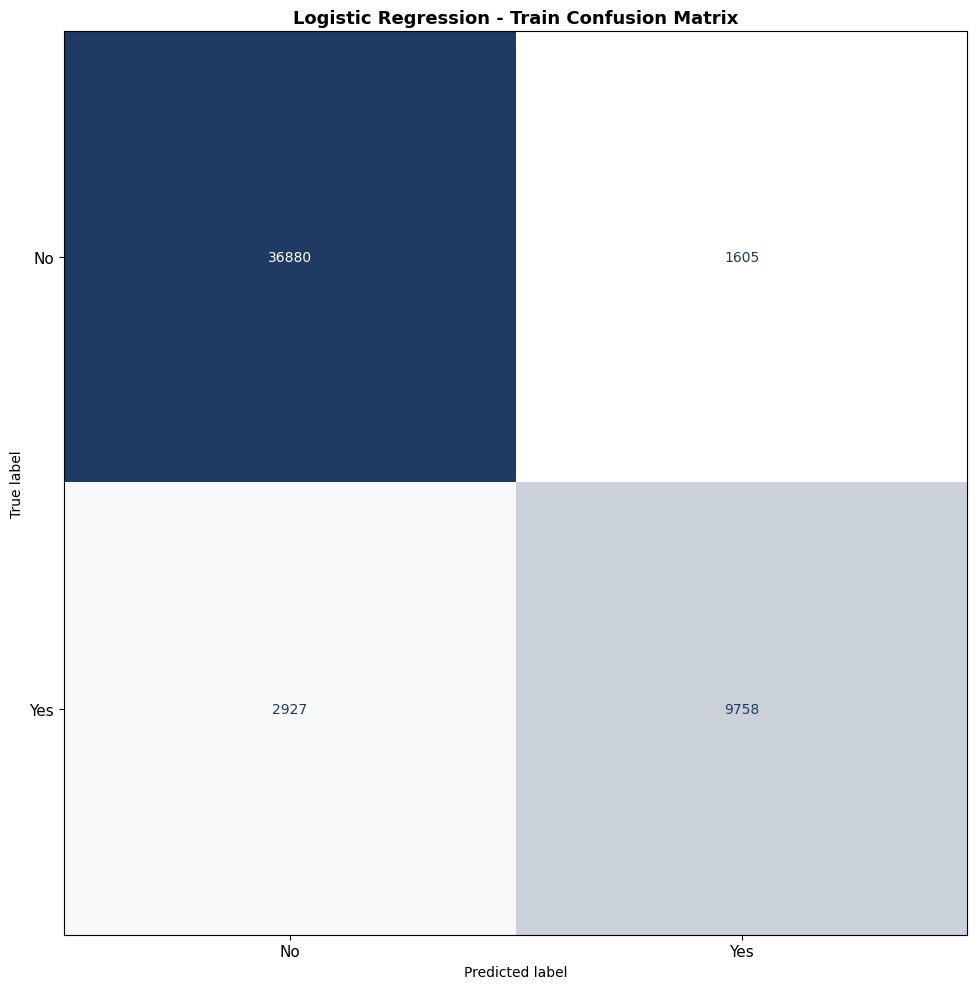

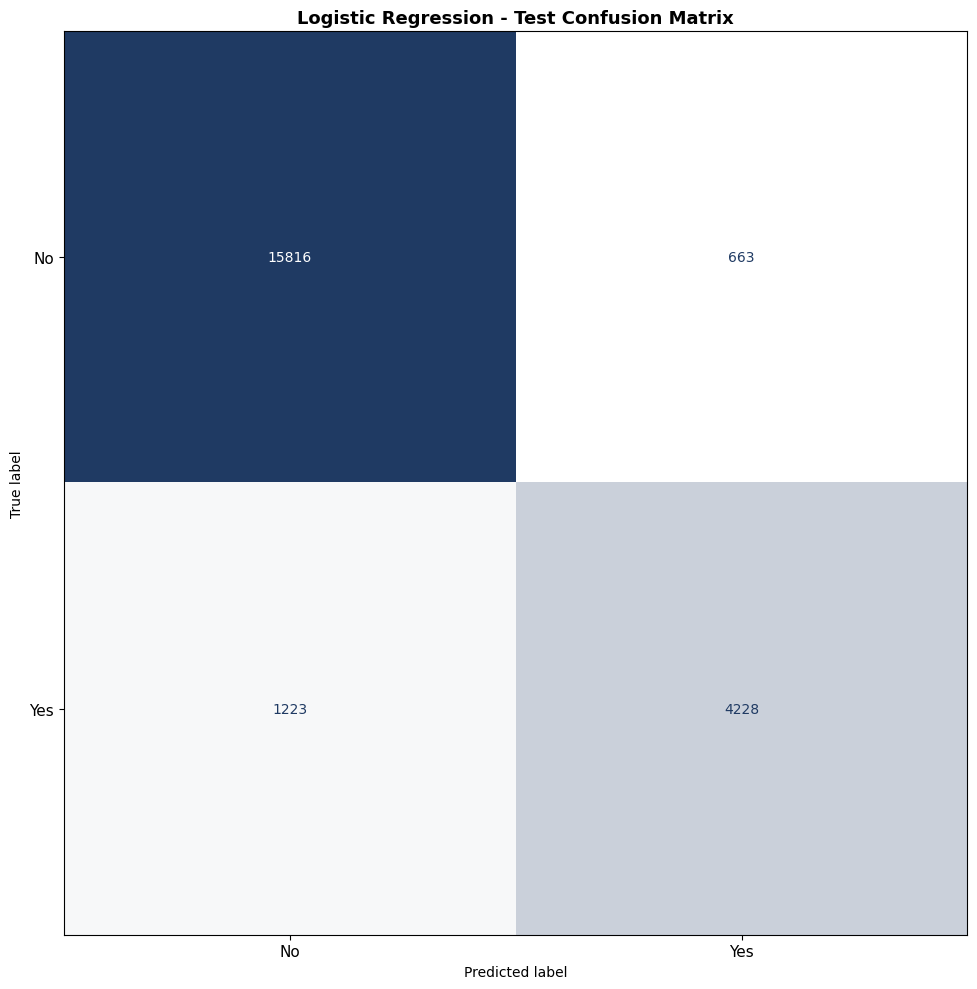

Train Report:
               precision    recall  f1-score   support

          No       0.93      0.96      0.94     38485
         Yes       0.86      0.77      0.81     12685

    accuracy                           0.91     51170
   macro avg       0.89      0.86      0.88     51170
weighted avg       0.91      0.91      0.91     51170

Test Report:
               precision    recall  f1-score   support

          No       0.93      0.96      0.94     16479
         Yes       0.86      0.78      0.82      5451

    accuracy                           0.91     21930
   macro avg       0.90      0.87      0.88     21930
weighted avg       0.91      0.91      0.91     21930

ROC AUC Score (Train): 0.9662813184154748
ROC AUC Score (Test): 0.9682374333008387
------------------------------------------------------------
Random Forest
-------------


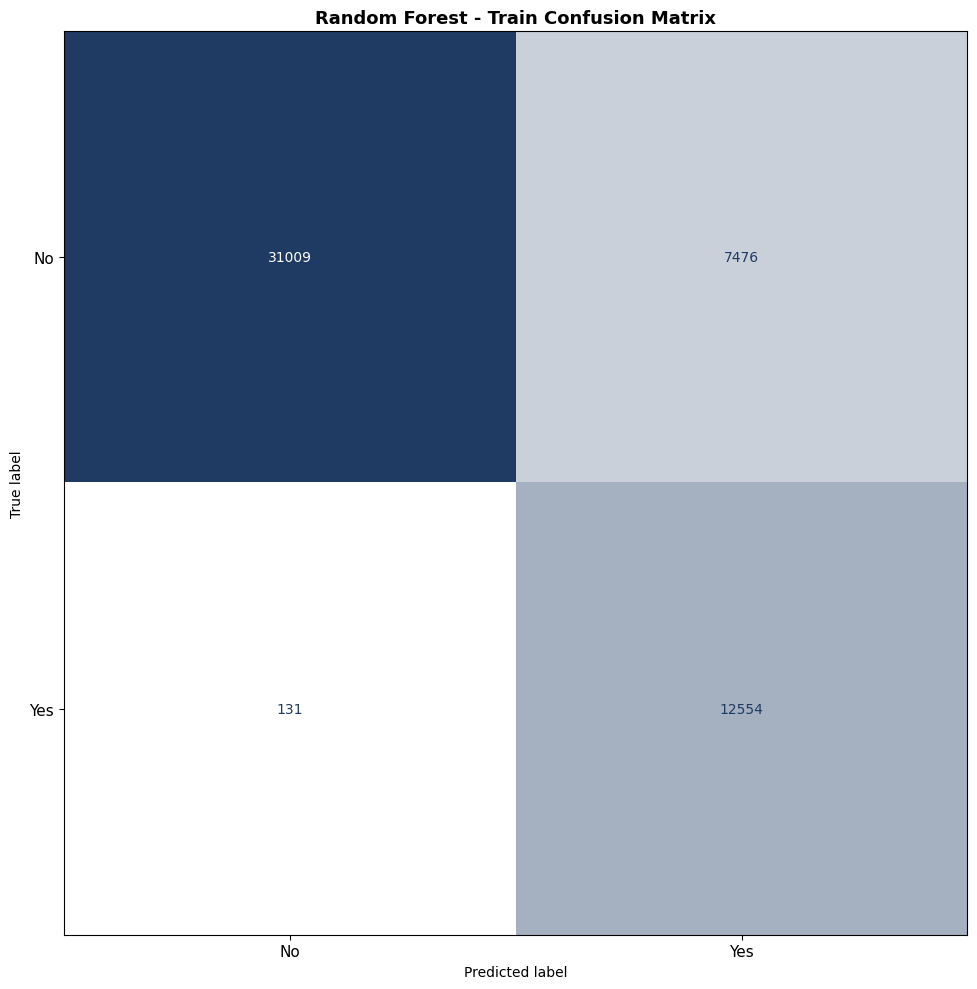

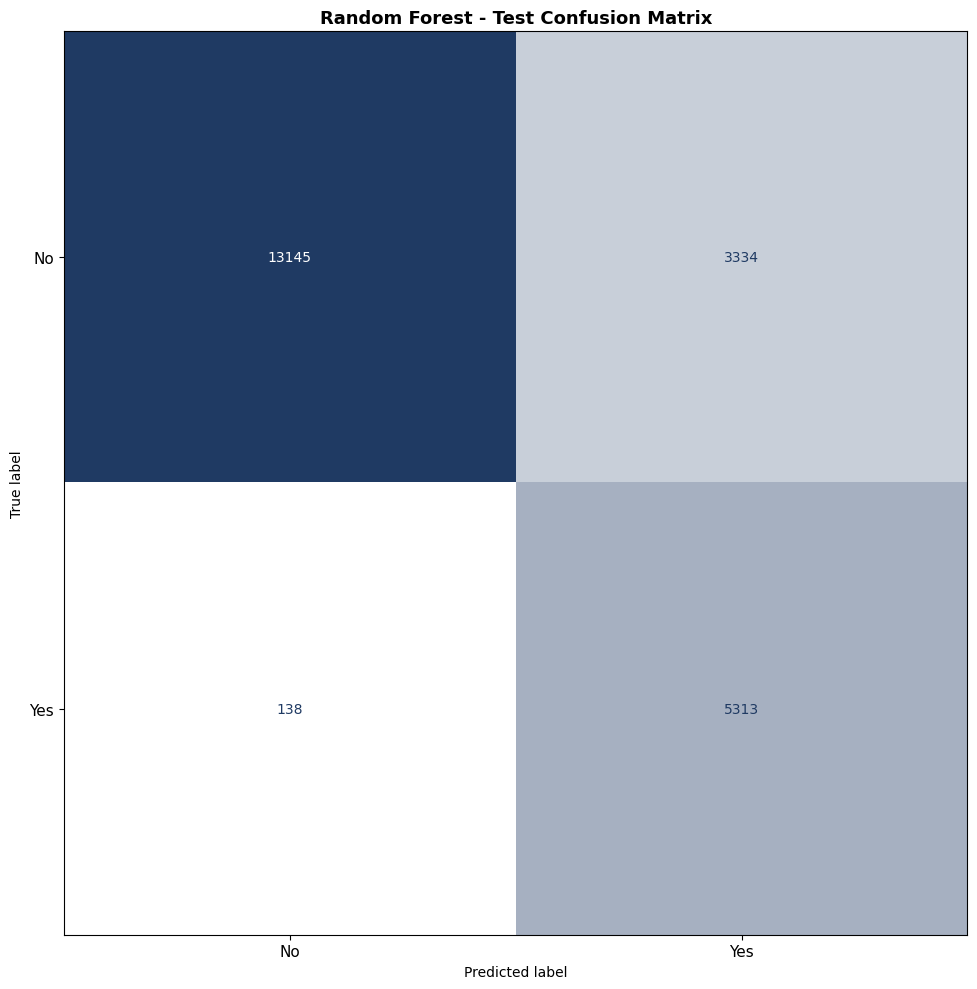

Train Report:
               precision    recall  f1-score   support

          No       1.00      0.81      0.89     38485
         Yes       0.63      0.99      0.77     12685

    accuracy                           0.85     51170
   macro avg       0.81      0.90      0.83     51170
weighted avg       0.90      0.85      0.86     51170

Test Report:
               precision    recall  f1-score   support

          No       0.99      0.80      0.88     16479
         Yes       0.61      0.97      0.75      5451

    accuracy                           0.84     21930
   macro avg       0.80      0.89      0.82     21930
weighted avg       0.90      0.84      0.85     21930

ROC AUC Score (Train): 0.9869083230140137
ROC AUC Score (Test): 0.9718512898829149
------------------------------------------------------------
XGBoost
-------


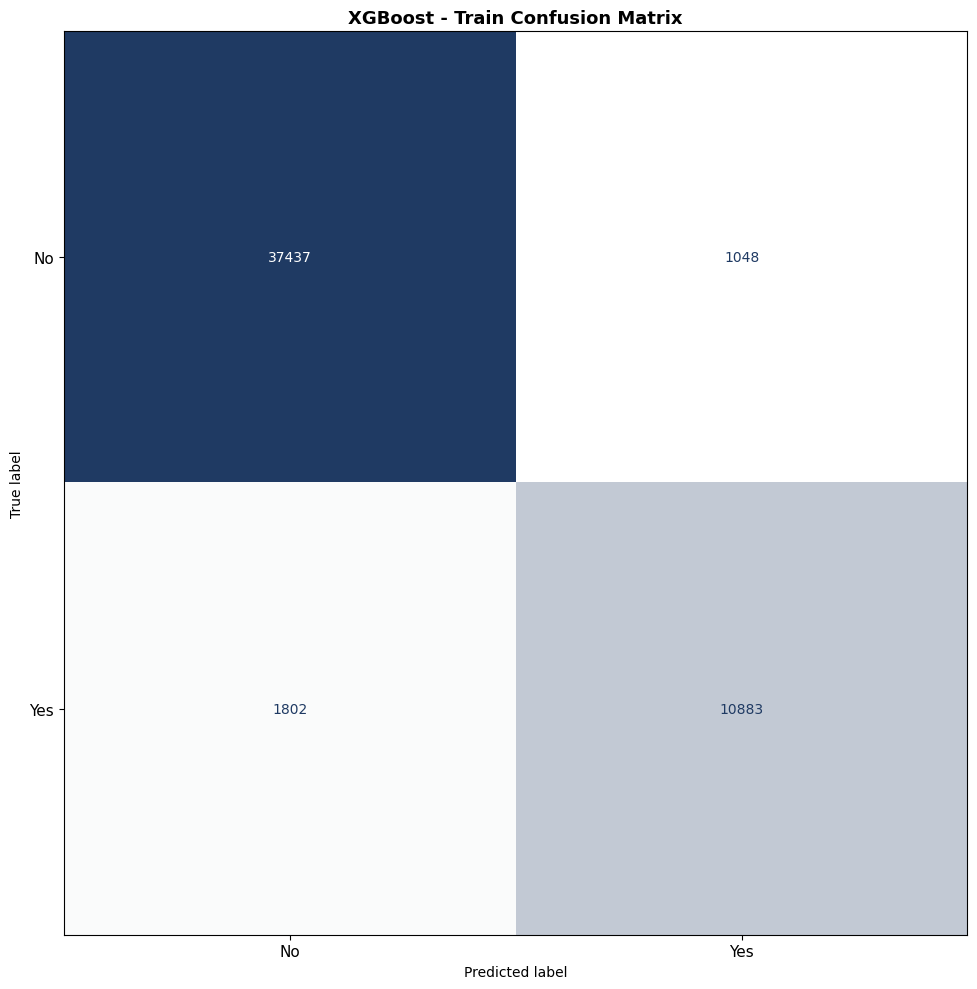

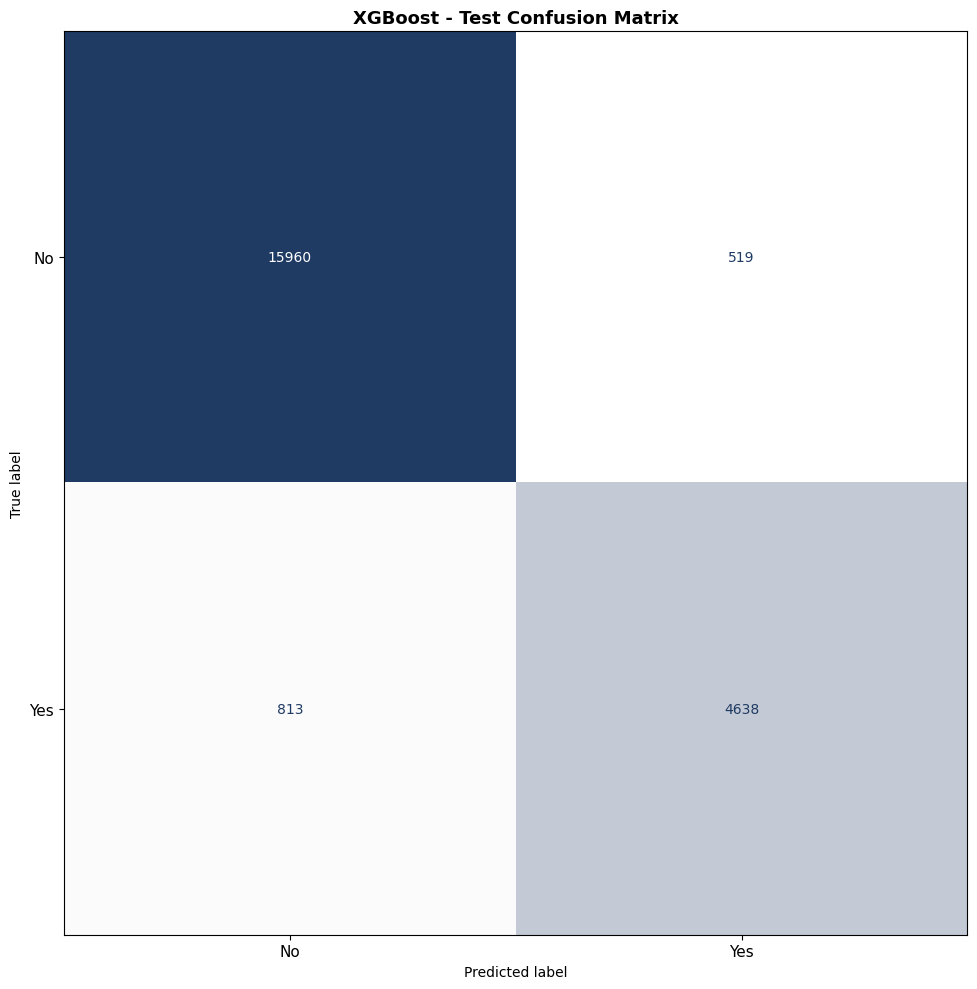

Train Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     38485
           1       0.91      0.86      0.88     12685

    accuracy                           0.94     51170
   macro avg       0.93      0.92      0.92     51170
weighted avg       0.94      0.94      0.94     51170

Test Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     16479
           1       0.90      0.85      0.87      5451

    accuracy                           0.94     21930
   macro avg       0.93      0.91      0.92     21930
weighted avg       0.94      0.94      0.94     21930

ROC AUC Score (Train): 0.9885004364917218
ROC AUC Score (Test): 0.986157451561712
------------------------------------------------------------
LinearSVC
---------


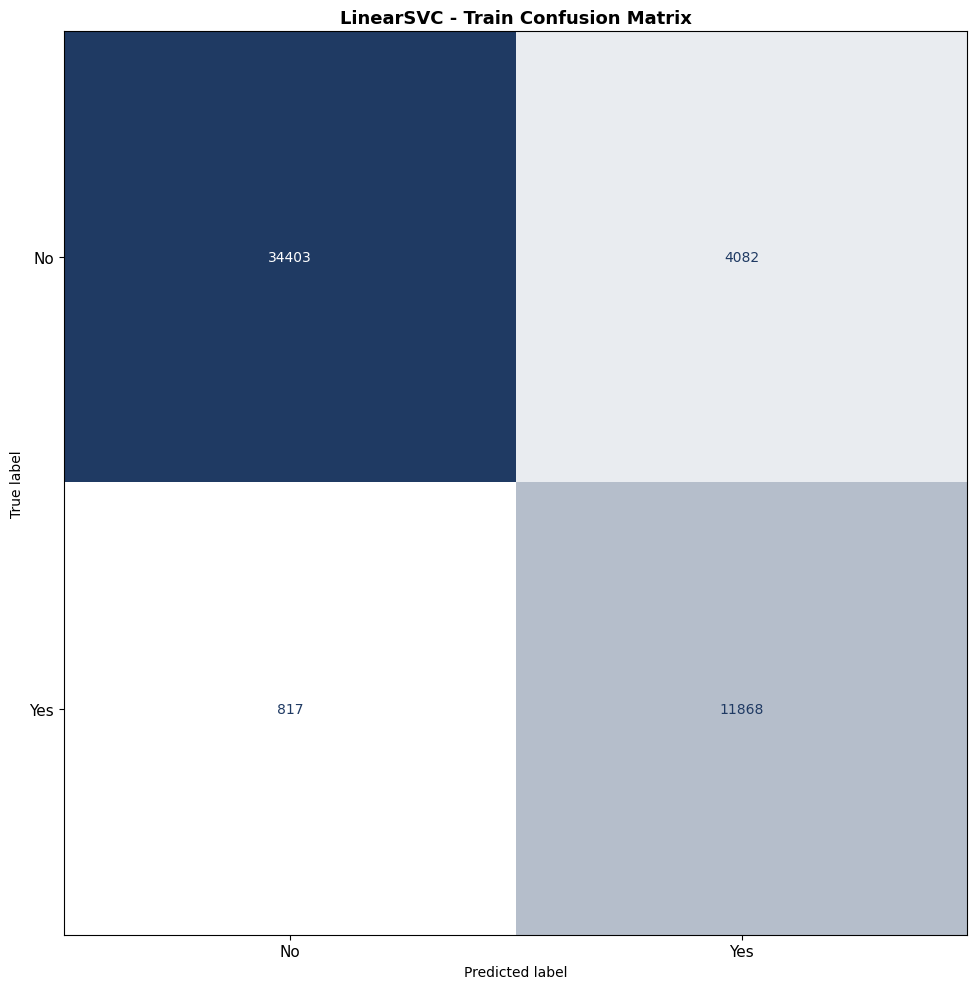

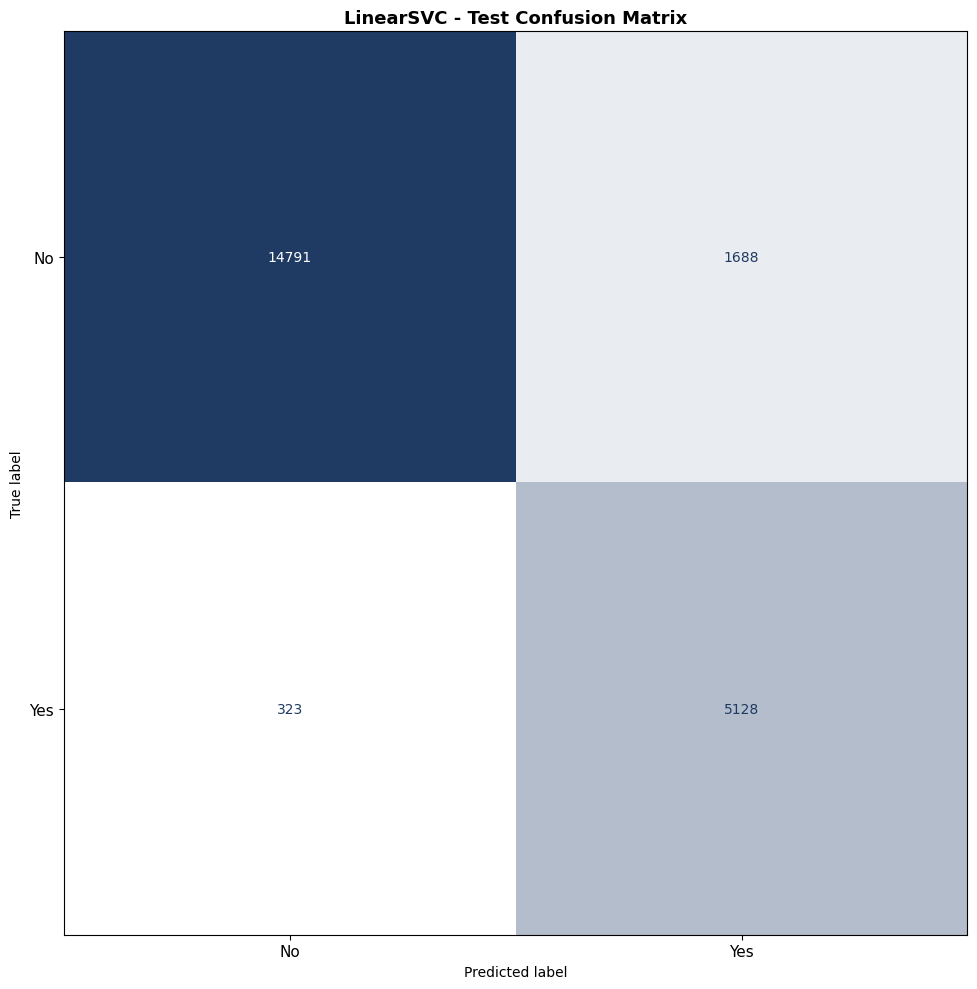

Train Report:
               precision    recall  f1-score   support

          No       0.98      0.89      0.93     38485
         Yes       0.74      0.94      0.83     12685

    accuracy                           0.90     51170
   macro avg       0.86      0.91      0.88     51170
weighted avg       0.92      0.90      0.91     51170

Test Report:
               precision    recall  f1-score   support

          No       0.98      0.90      0.94     16479
         Yes       0.75      0.94      0.84      5451

    accuracy                           0.91     21930
   macro avg       0.87      0.92      0.89     21930
weighted avg       0.92      0.91      0.91     21930

ROC AUC Score (Train): 0.9670362230005404
ROC AUC Score (Test): 0.9688844100588032
------------------------------------------------------------
LightGBM
--------


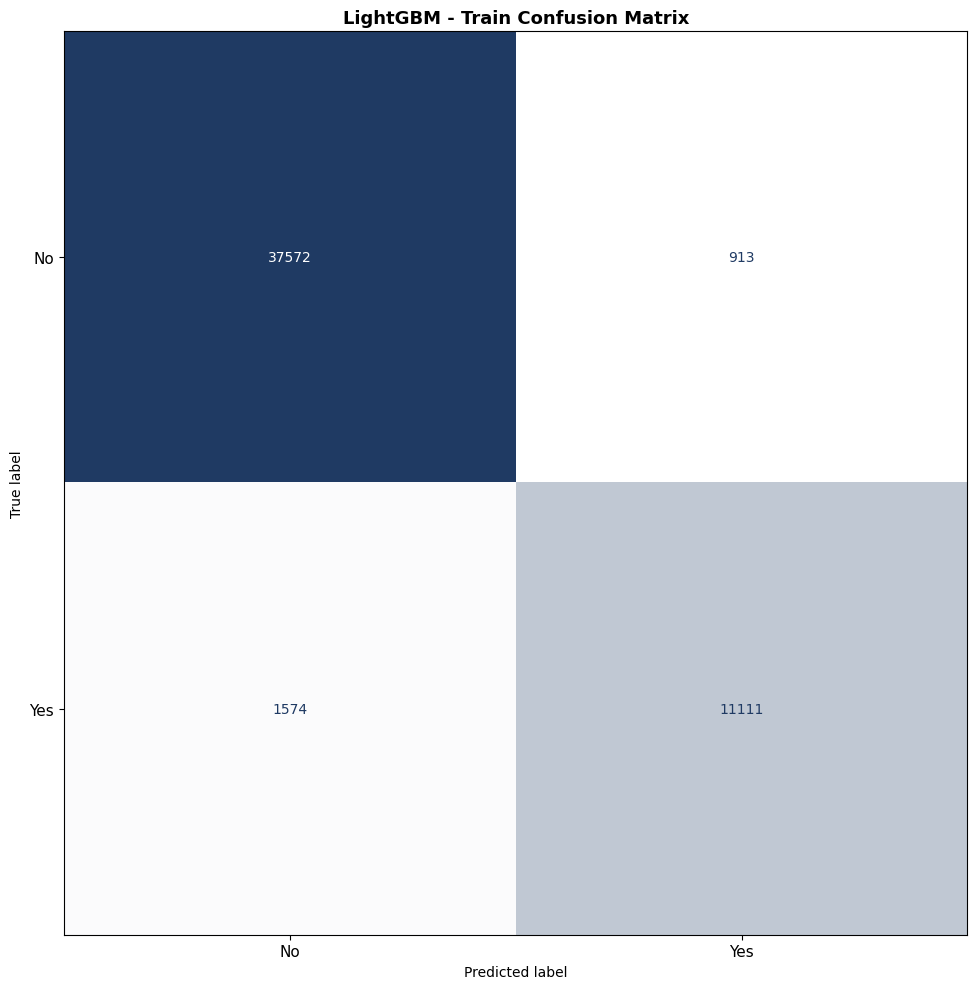

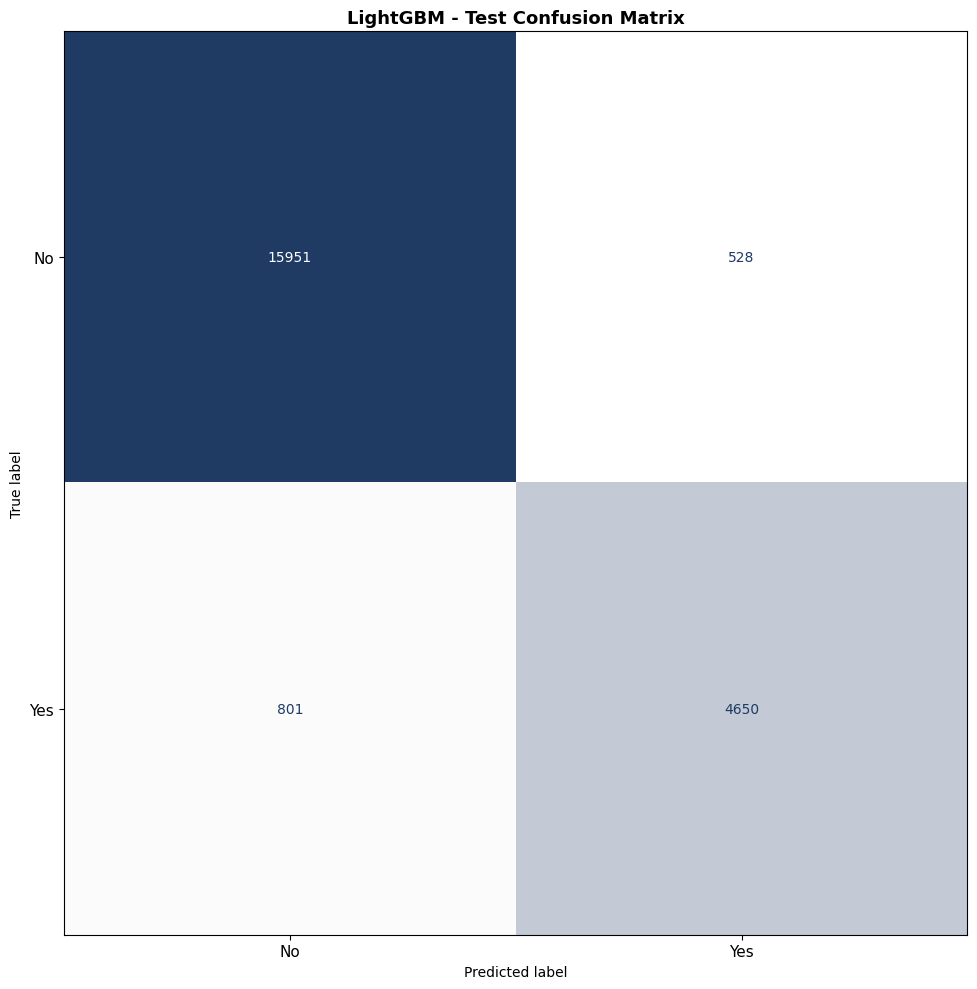

Train Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     38485
           1       0.92      0.88      0.90     12685

    accuracy                           0.95     51170
   macro avg       0.94      0.93      0.93     51170
weighted avg       0.95      0.95      0.95     51170

Test Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     16479
           1       0.90      0.85      0.87      5451

    accuracy                           0.94     21930
   macro avg       0.93      0.91      0.92     21930
weighted avg       0.94      0.94      0.94     21930

ROC AUC Score (Train): 0.991374922550693
ROC AUC Score (Test): 0.9865006277787501
------------------------------------------------------------
MLPClassifier
-------------


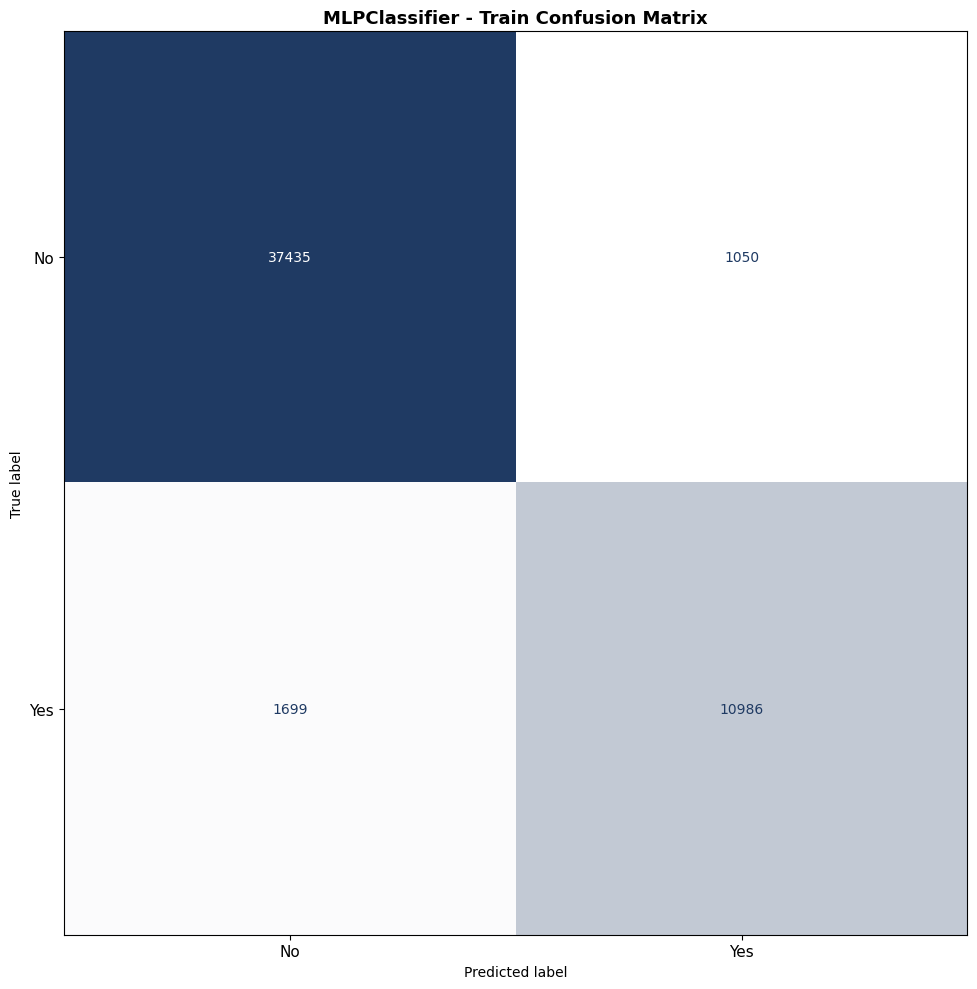

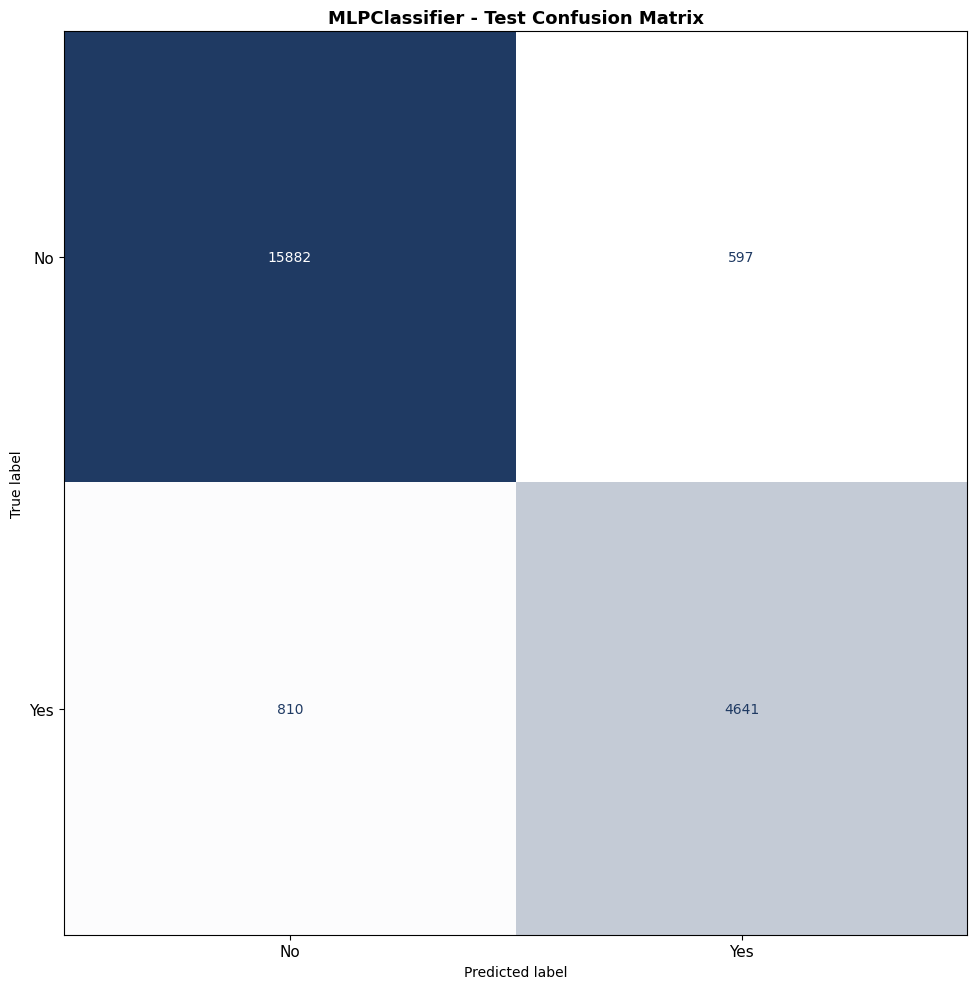

Train Report:
               precision    recall  f1-score   support

          No       0.96      0.97      0.96     38485
         Yes       0.91      0.87      0.89     12685

    accuracy                           0.95     51170
   macro avg       0.93      0.92      0.93     51170
weighted avg       0.95      0.95      0.95     51170

Test Report:
               precision    recall  f1-score   support

          No       0.95      0.96      0.96     16479
         Yes       0.89      0.85      0.87      5451

    accuracy                           0.94     21930
   macro avg       0.92      0.91      0.91     21930
weighted avg       0.94      0.94      0.94     21930

ROC AUC Score (Train): 0.9887948808459793
ROC AUC Score (Test): 0.9849559201162046
------------------------------------------------------------
Decision Tree
-------------


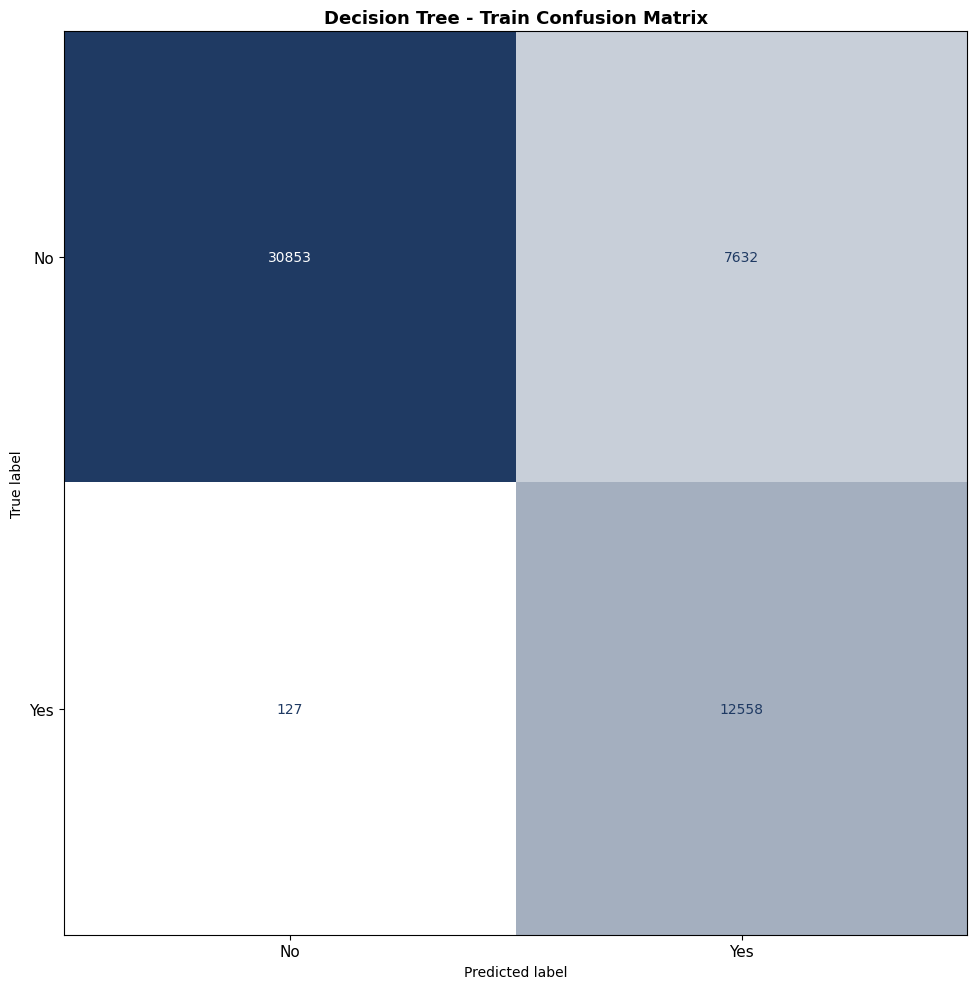

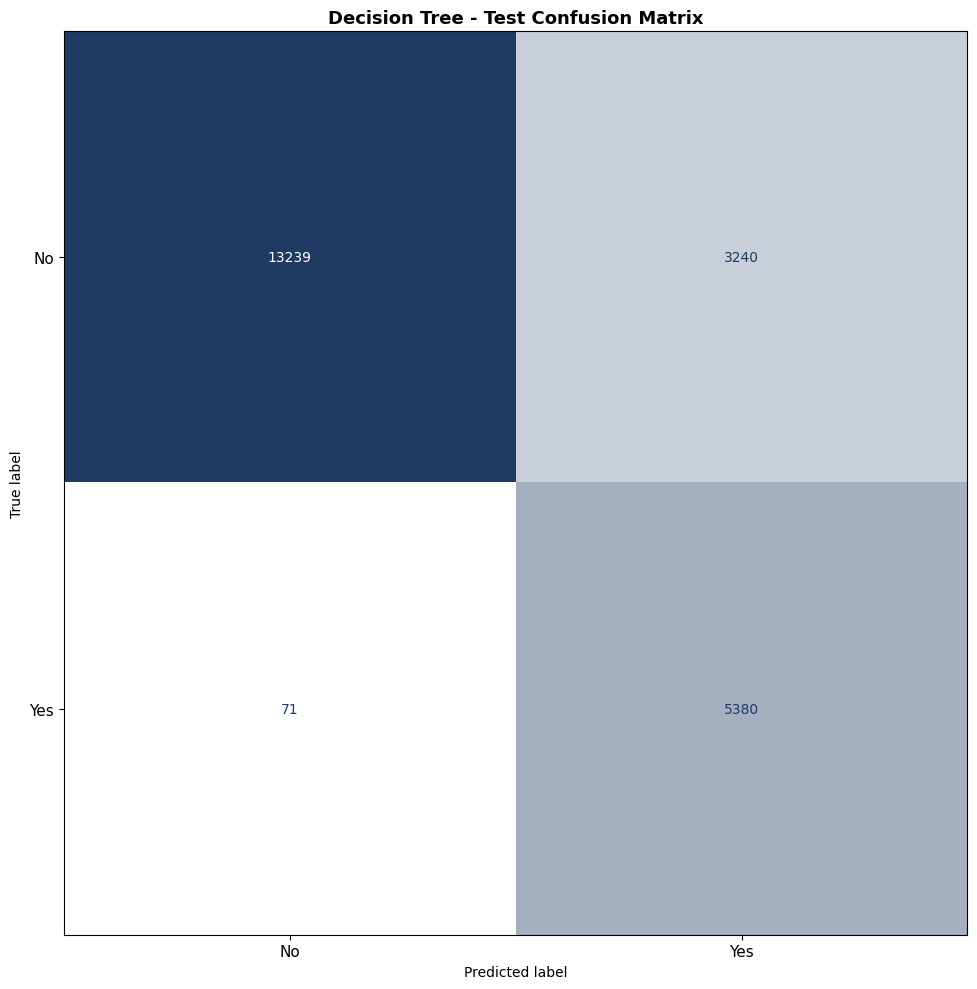

Train Report:
               precision    recall  f1-score   support

          No       1.00      0.80      0.89     38485
         Yes       0.62      0.99      0.76     12685

    accuracy                           0.85     51170
   macro avg       0.81      0.90      0.83     51170
weighted avg       0.90      0.85      0.86     51170

Test Report:
               precision    recall  f1-score   support

          No       0.99      0.80      0.89     16479
         Yes       0.62      0.99      0.76      5451

    accuracy                           0.85     21930
   macro avg       0.81      0.90      0.83     21930
weighted avg       0.90      0.85      0.86     21930

ROC AUC Score (Train): 0.9594425780250397
ROC AUC Score (Test): 0.957906628527144
------------------------------------------------------------
AdaBoost
--------


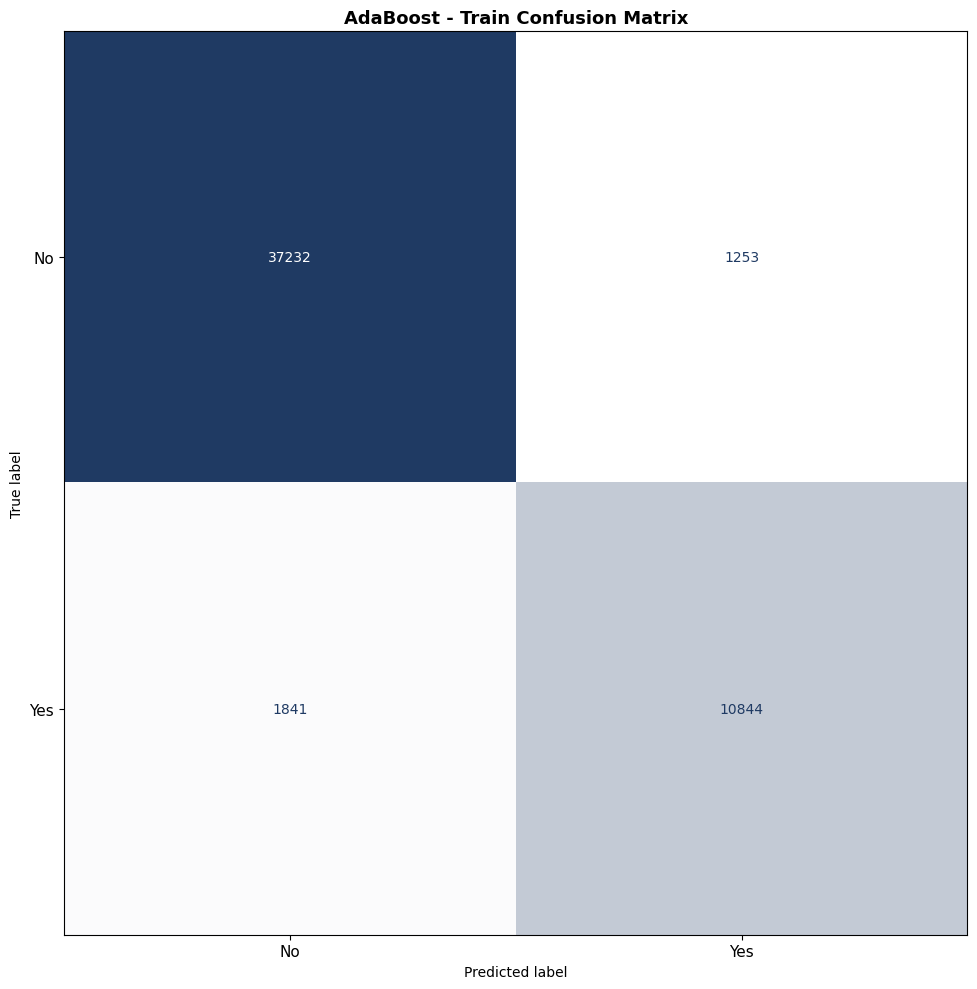

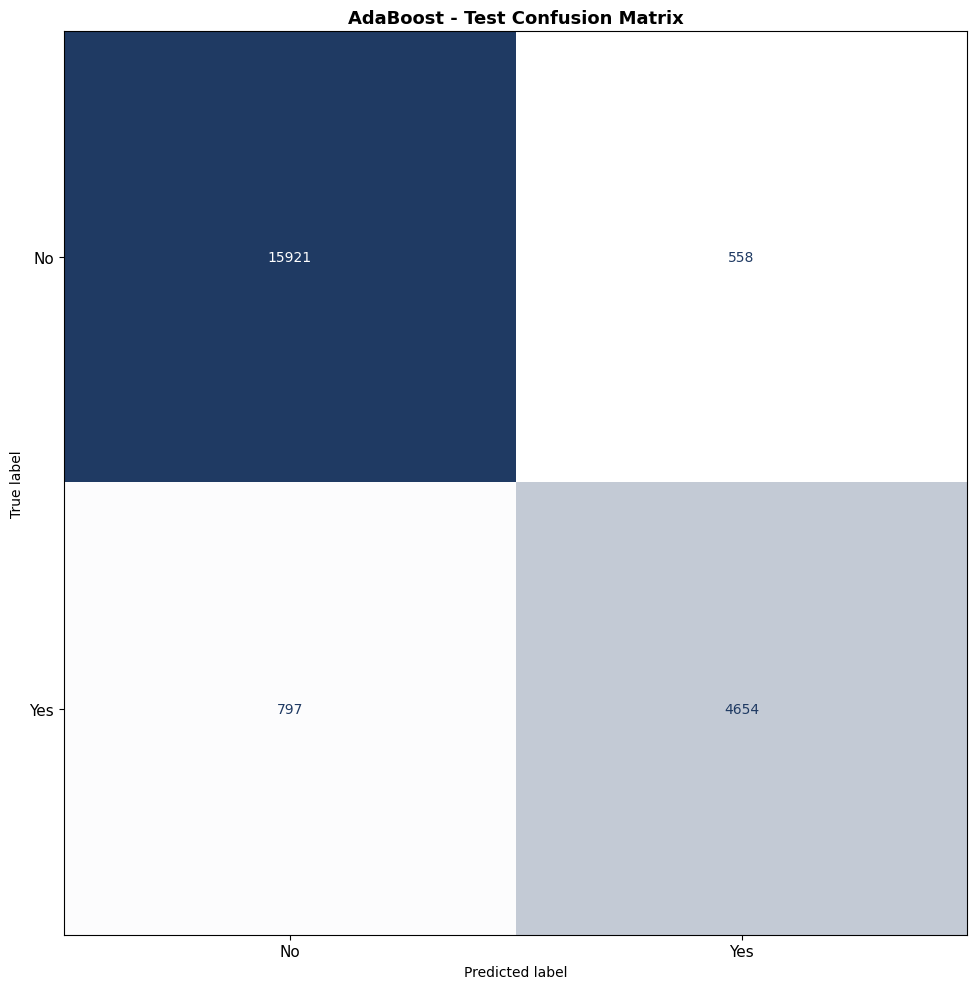

Train Report:
               precision    recall  f1-score   support

          No       0.95      0.97      0.96     38485
         Yes       0.90      0.85      0.88     12685

    accuracy                           0.94     51170
   macro avg       0.92      0.91      0.92     51170
weighted avg       0.94      0.94      0.94     51170

Test Report:
               precision    recall  f1-score   support

          No       0.95      0.97      0.96     16479
         Yes       0.89      0.85      0.87      5451

    accuracy                           0.94     21930
   macro avg       0.92      0.91      0.92     21930
weighted avg       0.94      0.94      0.94     21930

ROC AUC Score (Train): 0.9862441980553471
ROC AUC Score (Test): 0.9852405560468888
------------------------------------------------------------
KNN
---


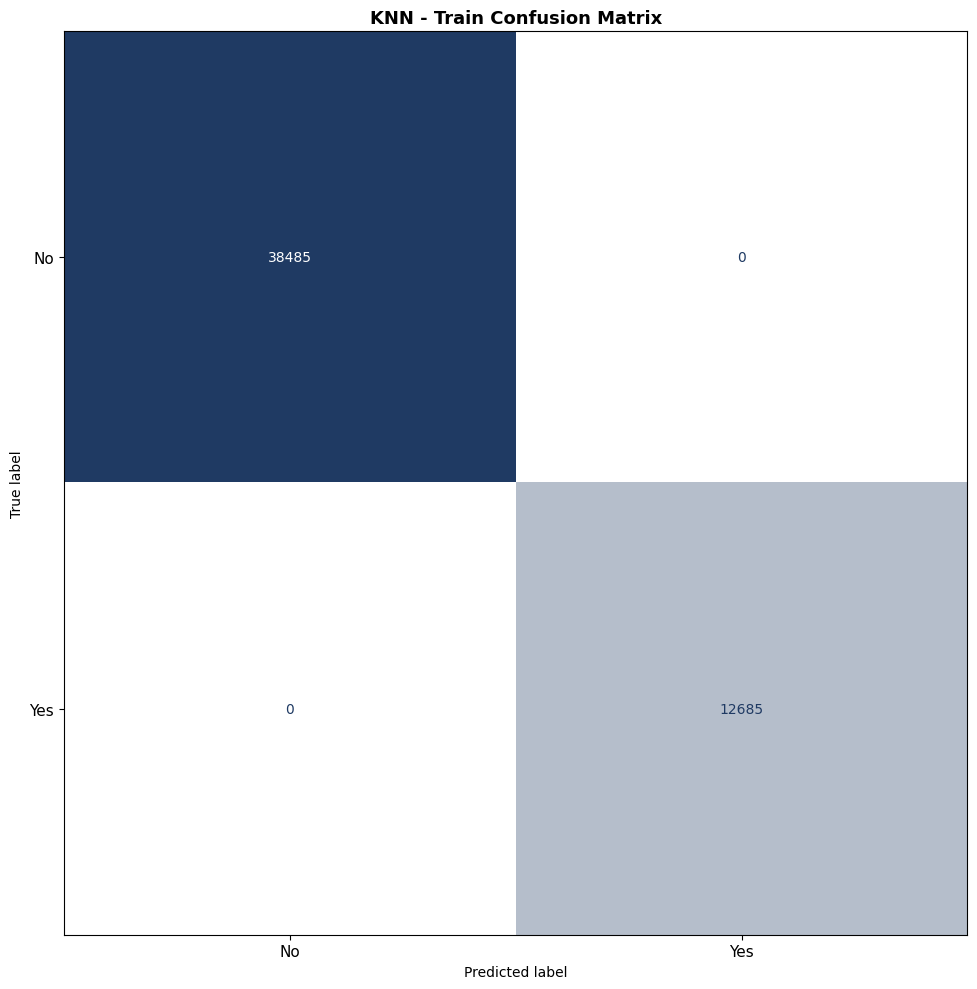

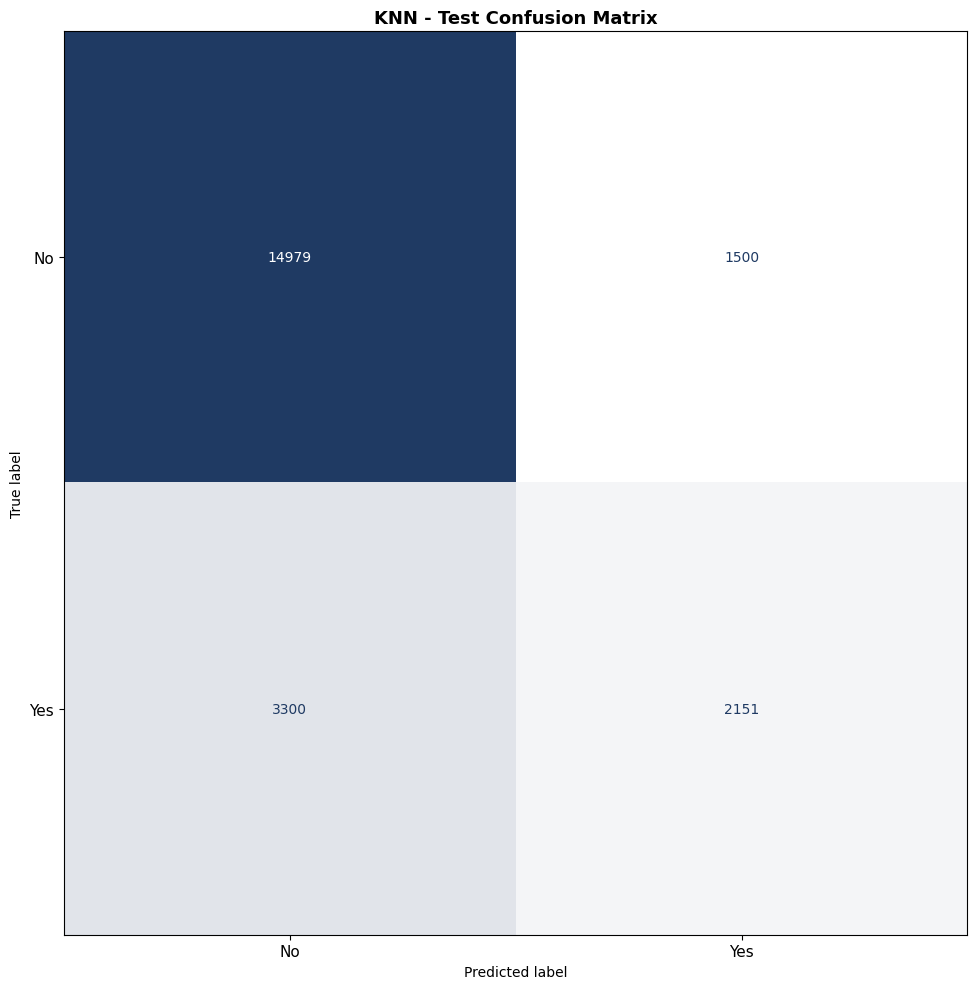

Train Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00     38485
         Yes       1.00      1.00      1.00     12685

    accuracy                           1.00     51170
   macro avg       1.00      1.00      1.00     51170
weighted avg       1.00      1.00      1.00     51170

Test Report:
               precision    recall  f1-score   support

          No       0.82      0.91      0.86     16479
         Yes       0.59      0.39      0.47      5451

    accuracy                           0.78     21930
   macro avg       0.70      0.65      0.67     21930
weighted avg       0.76      0.78      0.77     21930

ROC AUC Score (Train): 1.0
ROC AUC Score (Test): 0.7597989576166436
------------------------------------------------------------
Extra Trees
-----------


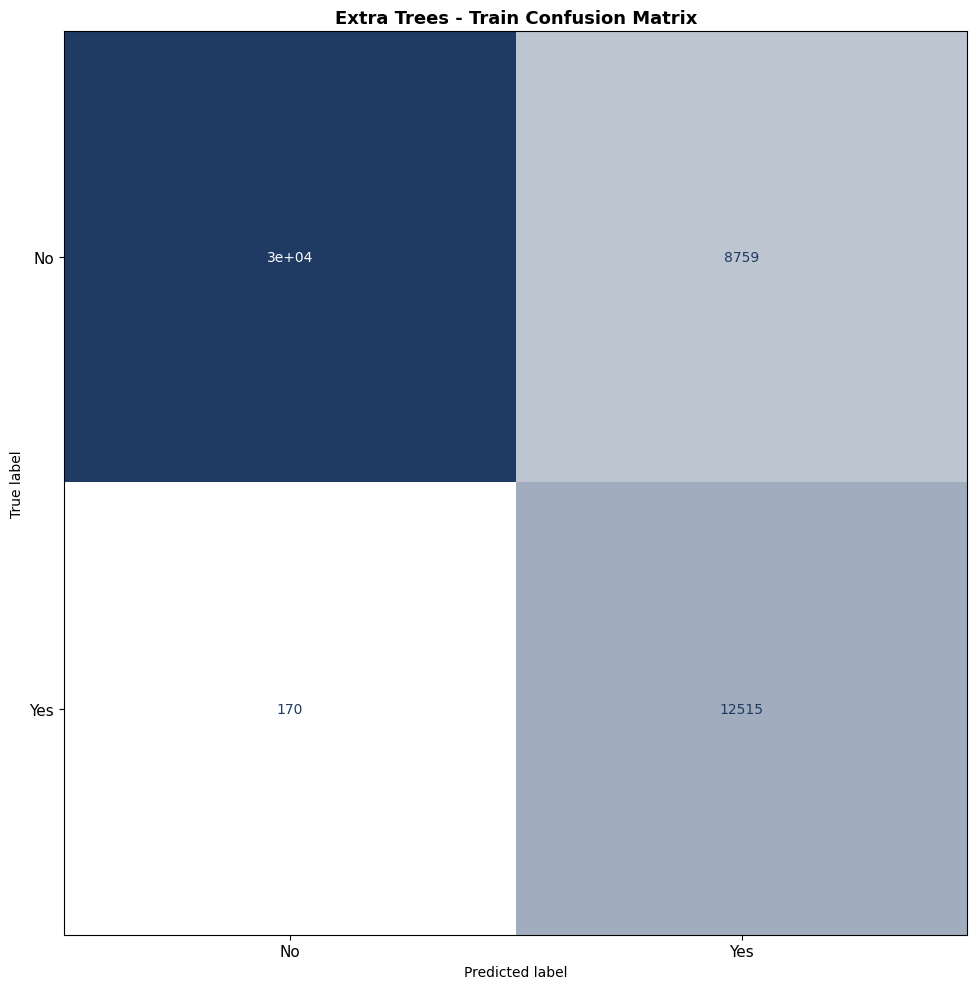

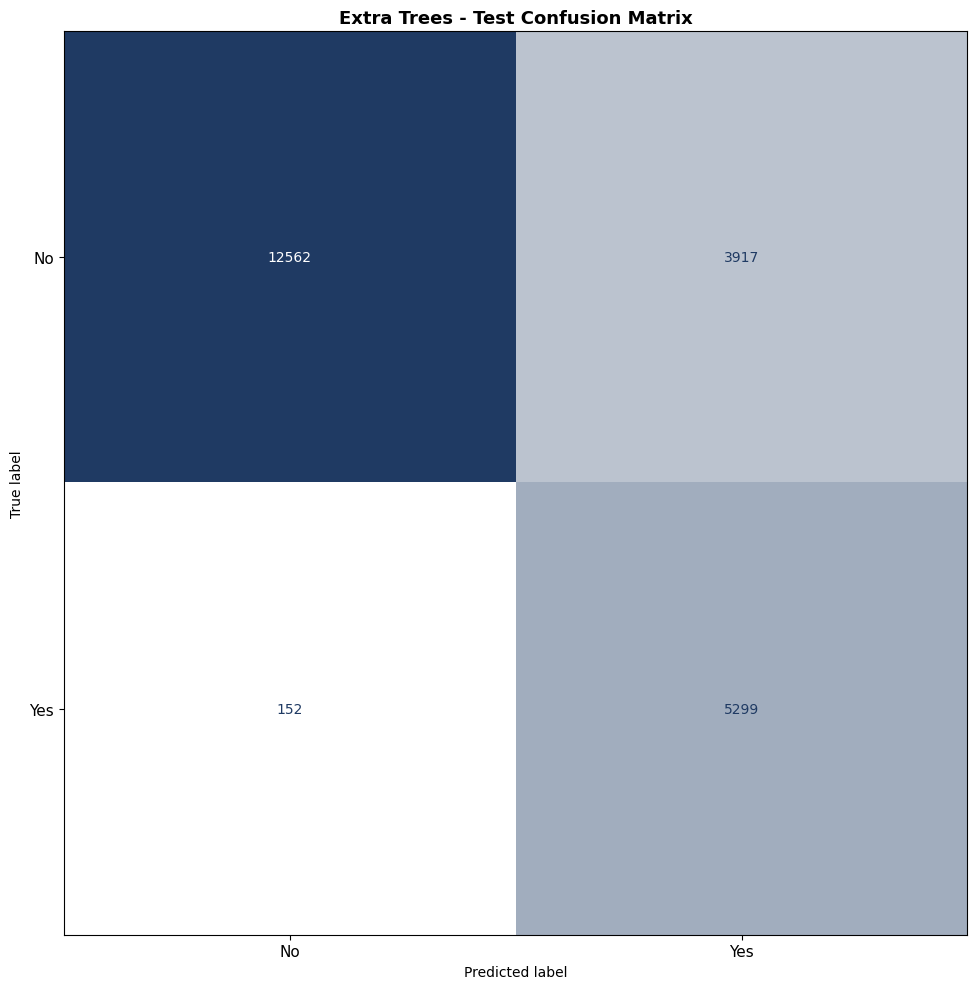

Train Report:
               precision    recall  f1-score   support

          No       0.99      0.77      0.87     38485
         Yes       0.59      0.99      0.74     12685

    accuracy                           0.83     51170
   macro avg       0.79      0.88      0.80     51170
weighted avg       0.89      0.83      0.84     51170

Test Report:
               precision    recall  f1-score   support

          No       0.99      0.76      0.86     16479
         Yes       0.57      0.97      0.72      5451

    accuracy                           0.81     21930
   macro avg       0.78      0.87      0.79     21930
weighted avg       0.89      0.81      0.83     21930

ROC AUC Score (Train): 0.9697897501286534
ROC AUC Score (Test): 0.9485959732676899
------------------------------------------------------------


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define label order and a clean blue-to-white colormap
labels = ['No', 'Yes']
custom_blues = LinearSegmentedColormap.from_list("custom_blues", ['white', '#1F3A63'])

def plot_conf_matrix(y_true, y_pred, title):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=labels,
        cmap=custom_blues,
        colorbar=False
    )
    disp.ax_.set_title(title, fontsize=13, weight='bold')
    disp.ax_.tick_params(labelsize=11)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Define a dictionary of model info and variables to iterate over
models_info = [
    ("Logistic Regression", best_log, y_train, y_test, "predict_proba"),
    ("Random Forest", best_rf, y_train, y_test, "predict_proba"),
    ("XGBoost", best_xgb, y_train_enc, y_test_enc, "predict_proba"),
    ("LinearSVC", best_linear_svc, y_train, y_test, "decision_function"),
    ("LightGBM", best_lgb, y_train_enc, y_test_enc, "predict_proba"),
    ("MLPClassifier", best_mlp, y_train, y_test, "predict_proba"),
    ("Decision Tree", best_dt, y_train, y_test, "predict_proba"),
    ("AdaBoost", best_ab, y_train, y_test, "predict_proba"),
    ("KNN", best_knn, y_train, y_test, "predict_proba"),
    ("Extra Trees", best_et, y_train, y_test, "predict_proba")
]

for name, model, y_train_true, y_test_true, proba_method in models_info:
    print(name)
    print("-" * len(name))
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    plot_conf_matrix(y_train_true, y_train_pred, f"{name} - Train Confusion Matrix")
    plot_conf_matrix(y_test_true, y_test_pred, f"{name} - Test Confusion Matrix")
    print("Train Report:\n", classification_report(y_train_true, y_train_pred))
    print("Test Report:\n", classification_report(y_test_true, y_test_pred))

    # Compute ROC AUC using the correct probability method
    if proba_method == "predict_proba":
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)

    print("ROC AUC Score (Train):", roc_auc_score(y_train_true, y_train_proba))
    print("ROC AUC Score (Test):", roc_auc_score(y_test_true, y_test_proba))
    print("-" * 60)

In [ ]:
# Fixing the mismatched lengths in the dataset
# Ensuring each list has exactly 22 entries

n_entries = 22

# Creating consistent placeholder data for columns
def pad_to_length(lst, length, fill=None):
    return lst + [fill] * (length - len(lst))

df_data = {
    "Model": pad_to_length([
        "Logistic Regression", "Logistic Regression",
        "GaussianNB",
        "LinearSVC", "LinearSVC",
        "Random Forest", "Random Forest",
        "XGBoost", "XGBoost",
        "LightGBM", "LightGBM",
        "MLPClassifier", "MLPClassifier",
        "Decision Tree", "Decision Tree",
        "AdaBoost", "AdaBoost",
        "KNN", "KNN",
        "Extra Trees", "Extra Trees"
    ], n_entries),
    "Tuning": pad_to_length([
        "Before", "After",
        "NA",
        "Before", "After",
        "Before", "After",
        "Before", "After",
        "Before", "After",
        "Before", "After",
        "Before", "After",
        "Before", "After",
        "Before", "After"
    ], n_entries),
    "Train Accuracy": pad_to_length([
        0.83, 0.91,
        0.75,
        0.91, 0.91,
        1.00, 0.84,
        0.97, 0.94,
        0.95, 0.95,
        0.95, 0.95,
        1.00, 0.85,
        0.93, 0.94,
        0.90, 0.85,
        1.00, 0.83
    ], n_entries),
    "Train Precision (Yes)": pad_to_length([
        0.59, 0.86,
        0.50,
        0.87, 0.75,
        1.00, 0.61,
        0.95, 0.91,
        0.92, 0.91,
        0.93, 0.91,
        1.00, 0.61,
        0.92, 0.90,
        0.89, 0.61,
        1.00, 0.59
    ], n_entries),
    "Train Recall (Yes)": pad_to_length([
        0.99, 0.77,
        0.42,
        0.73, 0.94,
        1.00, 0.99,
        0.91, 0.88,
        0.88, 0.87,
        0.86, 0.87,
        1.00, 0.99,
        0.78, 0.85,
        0.67, 0.99,
        1.00, 0.99
    ], n_entries),
    "Train F1 (Yes)": pad_to_length([
        0.74, 0.81,
        0.46,
        0.79, 0.84,
        1.00, 0.76,
        0.93, 0.90,
        0.90, 0.89,
        0.89, 0.89,
        1.00, 0.76,
        0.84, 0.87,
        0.76, 0.76,
        1.00, 0.74
    ], n_entries),
    "Train ROC AUC": pad_to_length([
        0.9698, 0.9663,
        0.8174,
        0.9646, 0.9689,
        1.0000, 0.9869,
        0.9956, 0.9885,
        0.9916, 0.9914,
        0.9894, 0.9888,
        1.0000, 0.9594,
        0.9811, 0.9862,
        0.9544, 0.9597,
        1.0000, 0.9698
    ], n_entries),
    "Test Accuracy": pad_to_length([
        0.81, 0.91,
        0.75,
        0.91, 0.91,
        0.93, 0.84,
        0.94, 0.94,
        0.94, 0.94,
        0.94, 0.94,
        0.92, 0.85,
        0.93, 0.94,
        0.84, 0.78,
        0.89, 0.81
    ], n_entries),
    "Test Precision (Yes)": pad_to_length([
        0.57, 0.86,
        0.51,
        0.87, 0.75,
        0.92, 0.61,
        0.89, 0.90,
        0.90, 0.89,
        0.90, 0.89,
        0.84, 0.59,
        0.92, 0.89,
        0.77, 0.59,
        0.92, 0.57
    ], n_entries),
    "Test Recall (Yes)": pad_to_length([
        0.97, 0.78,
        0.43,
        0.74, 0.94,
        0.80, 0.97,
        0.86, 0.87,
        0.86, 0.85,
        0.84, 0.85,
        0.84, 0.97,
        0.77, 0.85,
        0.50, 0.97,
        0.62, 0.97
    ], n_entries),
    "Test F1 (Yes)": pad_to_length([
        0.72, 0.82,
        0.46,
        0.80, 0.84,
        0.85, 0.76,
        0.87, 0.88,
        0.88, 0.87,
        0.87, 0.87,
        0.84, 0.76,
        0.84, 0.87,
        0.61, 0.76,
        0.74, 0.72
    ], n_entries),
    "Test ROC AUC": pad_to_length([
        0.9486, 0.9688,
        0.8165,
        0.9667, 0.9689,
        0.9820, 0.9719,
        0.9850, 0.9866,
        0.9865, 0.9866,
        0.9841, 0.9846,
        0.8931, 0.9579,
        0.9803, 0.9852,
        0.8729, 0.7598,
        0.9654, 0.9486
    ], n_entries),
}

df_comparison_all = pd.DataFrame(df_data)

# Creating a MultiIndex with Model and Tuning
multi_index = pd.MultiIndex.from_tuples(
    list(zip(df_comparison_all["Model"], df_comparison_all["Tuning"])),
    names=["Model", "Tuning"]
)

# Dropping old index columns and assigning the MultiIndex
df_comparison_multi = df_comparison_all.drop(columns=["Model", "Tuning"])
df_comparison_multi.index = multi_index

# Display the multi-index formatted DataFrame
df_comparison_multi


Train Accuracy  Train Precision (Yes)  \
Model               Tuning                                          
Logistic Regression Before            0.83                   0.59   
                    After             0.91                   0.86   
GaussianNB          NA                0.75                   0.50   
LinearSVC           Before            0.91                   0.87   
                    After             0.91                   0.75   
Random Forest       Before            1.00                   1.00   
                    After             0.84                   0.61   
XGBoost             Before            0.97                   0.95   
                    After             0.94                   0.91   
LightGBM            Before            0.95                   0.92   
                    After             0.95                   0.91   
MLPClassifier       Before            0.95                   0.93   
                    After             0.95                   0.91   
Decision Tree       Before            1.00                   1.00   
                    After             0.85                   0.61   
AdaBoost            Before            0.93                   0.92   
                    After             0.94                   0.90   
KNN                 Before            0.90                   0.89   
                    After             0.85                   0.61   
Extra Trees         NaN               1.00                   1.00   
                    NaN               0.83                   0.59   
NaN                 NaN                NaN                    NaN   

                            Train Recall (Yes)  Train F1 (Yes)  Train ROC AUC  \
Model               Tuning                                                      
Logistic Regression Before                0.99            0.74         0.9698   
                    After                 0.77            0.81         0.9663   
GaussianNB          NA                    0.42            0.46         0.8174   
LinearSVC           Before                0.73            0.79         0.9646   
                    After                 0.94            0.84         0.9689   
Random Forest       Before                1.00            1.00         1.0000   
                    After                 0.99            0.76         0.9869   
XGBoost             Before                0.91            0.93         0.9956   
                    After                 0.88            0.90         0.9885   
LightGBM            Before                0.88            0.90         0.9916   
                    After                 0.87            0.89         0.9914   
MLPClassifier       Before                0.86            0.89         0.9894   
                    After                 0.87            0.89         0.9888   
Decision Tree       Before                1.00            1.00         1.0000   
                    After                 0.99            0.76         0.9594   
AdaBoost            Before                0.78            0.84         0.9811   
                    After                 0.85            0.87         0.9862   
KNN                 Before                0.67            0.76         0.9544   
                    After                 0.99            0.76         0.9597   
Extra Trees         NaN                   1.00            1.00         1.0000   
                    NaN                   0.99            0.74         0.9698   
NaN                 NaN                    NaN             NaN            NaN   

                            Test Accuracy  Test Precision (Yes)  \
Model               Tuning                                        
Logistic Regression Before           0.81                  0.57   
                    After            0.91                  0.86   
GaussianNB          NA               0.75                  0.51   
LinearSVC           Before           0.91                  0.87   
                    Afte

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Create DataFrame
data = {
    "Model": [
        "Logistic Regression", "Gaussian Naive Bayes", "Linear Support Vector Classifier",
        "Random Forest", "XGBoost", "LightGBM", "Multi-Layer Perceptron",
        "Decision Tree", "AdaBoost", "K-Nearest Neighbors", "Extra Trees"
    ],
    "F1 (Before)": [0.82, 0.46, 0.80, 0.85, 0.87, 0.82, 0.86, 0.84, 0.84, 0.41, 0.74],
    "F1 (After)": [0.84, 0.60, 0.84, 0.86, 0.87, 0.88, 0.86, 0.84, 0.82, 0.64, 0.82],
    "Recall (Before)": [0.77, 0.43, 0.74, 0.80, 0.86, 0.77, 0.86, 0.84, 0.77, 0.31, 0.62],
    "Recall (After)": [0.93, 0.85, 0.93, 0.85, 0.87, 0.89, 0.89, 0.88, 0.97, 0.79, 0.77],
    "ROC-AUC (Before)": [0.968, 0.817, 0.967, 0.982, 0.985, 0.968, 0.983, 0.893, 0.980, 0.765, 0.965],
    "ROC-AUC (After)": [0.969, 0.816, 0.969, 0.980, 0.985, 0.986, 0.982, 0.905, 0.980, 0.859, 0.971],
    "ΔRecall": [0.16, 0.42, 0.19, 0.05, 0.01, 0.12, 0.03, 0.04, 0.20, 0.48, 0.15],
    "Overfitting Risk": ["No", "No", "No", "Yes", "No", "No", "Slightly", "Yes", "No", "No", "Yes"]
}

df = pd.DataFrame(data)

# Build Plotly Table
fig = go.Figure(data=[go.Table(
    columnwidth=[200, 80, 80, 100, 100, 120, 120, 80, 120],  # Adjust based on content
    header=dict(
        values=list(df.columns),
        fill_color='#1F3A63',
        font=dict(color='white', size=16),
        align='center'
    ),
    cells=dict(
        values=[df[col] for col in df.columns],
        fill_color=[['#F2F2F2', '#FFFFFF'] * (len(df) // 2 + 1)],
        font=dict(color='black', size=15),
        align=['left'] + ['center'] * (len(df.columns) - 1)  # Align left for Model, center for others
    )
)])

fig.update_layout(width=1200, height=600)
fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Data setup
data = {
    "Model": [
        "Logistic Regression", "Gaussian Naive Bayes", "Linear Support Vector Classifier",
        "Random Forest", "XGBoost", "LightGBM", "Multi-Layer Perceptron",
        "Decision Tree", "AdaBoost", "K-Nearest Neighbors", "Extra Trees"
    ],
    "F1 (Before)": [0.82, 0.46, 0.80, 0.85, 0.87, 0.82, 0.86, 0.84, 0.84, 0.41, 0.74],
    "F1 (After)": [0.84, 0.60, 0.84, 0.86, 0.87, 0.88, 0.86, 0.84, 0.82, 0.64, 0.82],
    "Recall (Before)": [0.77, 0.43, 0.74, 0.80, 0.86, 0.77, 0.86, 0.84, 0.77, 0.31, 0.62],
    "Recall (After)": [0.93, 0.85, 0.93, 0.85, 0.87, 0.89, 0.89, 0.88, 0.97, 0.79, 0.77],
    "ROC-AUC (Before)": [0.968, 0.817, 0.967, 0.982, 0.985, 0.968, 0.983, 0.893, 0.980, 0.765, 0.965],
    "ROC-AUC (After)": [0.969, 0.816, 0.969, 0.980, 0.985, 0.986, 0.982, 0.905, 0.980, 0.859, 0.971],
    "ΔRecall": [0.16, 0.42, 0.19, 0.05, 0.01, 0.12, 0.03, 0.04, 0.20, 0.48, 0.15],
    "Overfitting Risk": ["No", "No", "No", "Yes", "No", "No", "Slightly", "Yes", "No", "No", "Yes"]
}

df = pd.DataFrame(data)

# Insert line breaks in model names to increase row height
df["Model"] = df["Model"].apply(lambda x: x + "<br>")

# Create the table
fig = go.Figure(data=[go.Table(
    columnwidth=[300, 100, 80, 100, 100, 120, 120, 100, 120],
    header=dict(
        values=[f"<b>{col}</b>" for col in df.columns],
        fill_color='#1F3A63',
        font=dict(color='white', size=16),
        align=['center'],  # horizontal center
        height=30,
        line_color='black'  # border
    ),
    cells=dict(
        values=[df[col] for col in df.columns],
        fill_color=[['#F2F2F2', '#FFFFFF'] * (len(df) // 2 + 1)],
        font=dict(color='black', size=16),
        align=['left'] + ['center'] * (len(df.columns) - 1),
        height=40,
        line_color='black'  # borders
    )
)])

fig.update_layout(width=1200, height=700)
fig.show()